In [1]:
from collections import Counter, defaultdict
import datetime
import geopandas as gpd
import json
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import pgeocode
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances
from uszipcode import SearchEngine

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 22})

In [4]:
with open('denver_zipcodes.txt', 'r') as f:
    denver_zipcodes = sorted(json.loads(f.read()))

### Process Neighborhood Scout data

In [5]:
neighborhood_scout_dir = 'neighborhood_scout_data'

In [6]:
# dataframe mapping ZIP code to census tract (note: a census tract can be in multiple ZIP codes)
zipcode_mapping_df = pd.read_csv(f'{neighborhood_scout_dir}/zip_tract_crosswalk_2020.csv')
zipcode_mapping_df = zipcode_mapping_df[zipcode_mapping_df['ZIP'].isin(denver_zipcodes)]

In [7]:
zipcode_mapping_df.head()

,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
141258,80001,8059010305,1.000000,1.000000,1.000000,1.000000
141259,80002,8059010405,0.169287,0.211296,0.249720,0.180082
141260,80002,8059010308,0.273213,0.219934,0.220605,0.263049
141261,80002,8059010406,0.130031,0.324917,0.178052,0.156902
141262,80002,8059010304,0.000000,0.011296,0.008959,0.001998


In [8]:
# census tracts in Denver market area
denver_census_tracts = set(zipcode_mapping_df['TRACT'])

In [9]:
len(denver_census_tracts)

768

In [10]:
# dataframe reporting census tract-level statistics
all_ct_stats_df = pd.read_csv(f'{neighborhood_scout_dir}/census_tract_2020_q3.csv')

In [11]:
# census tracts in entire state of Colorado
colorado_census_tracts = set(all_ct_stats_df[all_ct_stats_df['state'] == 'CO']['ct_key'])

In [12]:
# limit analysis to census tracts in Denver market area
ct_stats_df = all_ct_stats_df[all_ct_stats_df['ct_key'].isin(denver_census_tracts)]
ct_stats_df.drop(columns=['state'], inplace=True)

In [13]:
ct_stats_df.shape

(767, 61)

In [14]:
ct_stats_df.isna().sum()

ct_key                 0
rent.ct                0
grrent_yield.ct        0
rent_br3.ct            0
rent_br2.ct            0
rent_br1.ct            0
rent_br0.ct            0
cos.ct                 0
lake.ct                0
frm.ct                 0
pop_density.ct         0
den.ct                 0
urb.ct                 0
sub.ct                 0
rur.ct                 0
rmt.ct                 0
new_pct.ct             0
est_pct.ct             0
old_pct.ct             0
his_pct.ct             0
det_pct.ct             0
att_pct.ct             0
sap_pct.ct             0
lap_pct.ct             0
mob_pct.ct             0
oth_pct.ct             0
bed0_pct.ct            0
bed1_pct.ct            0
bed2_pct.ct            0
bed3_pct.ct            0
bed4_pct.ct            0
bed5_pct.ct            0
base_pct.ct            0
dorms_pct.ct           0
incarc_pct.ct          0
publichou_pct.ct       0
own_pct.ct             0
rnt_pct.ct             0
seasonal_pct.ct        0
vacant_pct.ct          0


### School district data

In [15]:
# dataframe mapping school district to census tract
school_mapping_df = pd.read_csv(f'{neighborhood_scout_dir}/ct_schooldist_crosswalk_2020.csv')
school_mapping_df = school_mapping_df[['ct_key', 'leaid']]
ct_stats_df = ct_stats_df.merge(school_mapping_df, how='inner', on='ct_key')

In [16]:
ct_stats_df.shape

(872, 62)

In [17]:
# dataframe reporting statistics for each school district
school_district_df = pd.read_csv(f'{neighborhood_scout_dir}/school_district_2020.csv')
school_district_df.head()

,state,leaid,district_name.sd,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,AZ,400001,CAVE CREEK UNIFIED DISTRICT (4244),5406,8,23.102564,8,9,81.810155,77.117117
1,AZ,400003,CHINO VALLEY UNIFIED DISTRICT (4474),2348,4,20.271087,6,5,43.544623,50.630631
2,AZ,400004,CLARKDALE-JEROME ELEMENTARY DISTRICT (4486),472,1,20.521739,7,7,65.234942,66.306306
3,AZ,400005,SALOME CONSOLIDATED ELEMENTARY DISTRICT (4514),113,1,14.125,2,1,5.994954,13.603604
4,AZ,400021,COLORADO CITY UNIFIED DISTRICT (4370),673,2,23.614035,7,7,65.689057,66.846847


In [18]:
school_district_df['avg_member.sd'] = school_district_df['member.sd'] / school_district_df['sch.sd']

In [19]:
school_district_df.drop(columns=['state', 'district_name.sd', 'member.sd', 'sch.sd'], 
                        inplace=True, errors='ignore')

In [20]:
ct_stats_df = ct_stats_df.merge(school_district_df, how='inner', on='leaid')

In [21]:
ct_stats_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [22]:
# convert string columns to float
for column in ct_stats_df.columns:
    if ct_stats_df[column].dtype == 'object':
        ct_stats_df[column] = ct_stats_df[column].astype('float64')

In [23]:
ct_stats_df.shape

(872, 68)

In [24]:
# average statistics for census tracts that encompass multiple school districts
ct_stats_df = ct_stats_df.groupby('ct_key').mean().reset_index()
ct_stats_df.shape

(767, 68)

### Individual school data

In [25]:
# dataframe reporting statistics for each school 
school_building_df = pd.read_csv(f'{neighborhood_scout_dir}/school_building_2020.csv')
school_building_df = school_building_df[school_building_df['ct_key'].isin(denver_census_tracts)]
school_building_df.drop(columns=['state', 'ncessch', 'name.sc', 'street.sc', 'city.sc'],
                        inplace=True)

In [26]:
school_building_df.head(5)

,state.sc,zip.sc,ct_key,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
12839,CO,80010,8001007801,485,16.649502,1,2,13.874447,3.830084
12840,CO,80010,8001007802,336,18.300654,1,1,7.14554,.31337
12841,CO,80010,8001007900,11,84.615385,,,,
12842,CO,80010,8001007900,101,10.11011,1,1,5.34111,3.134796
12843,CO,80010,8001007900,117,10.427807,1,1,6.684897,.069638


In [27]:
print('fraction of census tracts with data on schools:', (len(school_building_df['ct_key'].unique()) / 
                                                          len(denver_census_tracts)))

fraction of census tracts with data on schools: 0.72265625


In [28]:
# the fact that the set is empty confirms that each census tract is served by at least one school that
# we have data on
school_building_df_no_missing_vals = school_building_df[school_building_df['stcls_total.sc'] != ' ']
set(school_building_df_no_missing_vals['ct_key']) - set(school_building_df['ct_key'])

set()

In [29]:
school_building_df = school_building_df_no_missing_vals

In [30]:
school_building_df[school_building_df['puptch.sc'] == ' ']

,state.sc,zip.sc,ct_key,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
14021,CO,80401,8059010000,3,,4,4,31.311981,38.871473


In [31]:
school_building_df.at[14021, 'puptch.sc'] = np.mean([float(x) for x in school_building_df['puptch.sc']
                                                     if x != ' '])

In [32]:
for column in ['stcls_total.sc', 'uscls_total.sc', 'member.sc', 'zip.sc']:
    school_building_df[column] = school_building_df[column].astype(int)
for column in ['puptch.sc', 'usrpct_total.sc', 'strpct_total.sc']:
    school_building_df[column] = school_building_df[column].astype(float)

In [33]:
school_building_df_zipcode = school_building_df.groupby('zip.sc').mean().reset_index().drop(columns=['ct_key'])

In [34]:
school_building_df_zipcode.head()

,zip.sc,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
0,80002,594.500000,17.143172,4.250000,4.750000,43.994332,37.273677
1,80003,372.818182,17.081377,3.727273,4.272727,38.647753,31.245252
2,80004,524.600000,16.976408,4.700000,5.200000,47.827115,42.078494
3,80005,723.300000,19.325791,7.800000,8.000000,76.417548,72.677577
4,80007,642.500000,20.195939,9.500000,9.500000,93.712665,90.477019


In [35]:
# calculate average school statistics for census tracts that encompass multiple schools
school_building_df_ct = school_building_df.groupby('ct_key').mean().reset_index()
school_building_df_ct.drop(columns=['zip.sc'], inplace=True)

In [36]:
census_tracts_with_school = set(school_building_df_ct['ct_key'])
has_school_df = pd.DataFrame([(ct, int(ct in census_tracts_with_school)) for ct in denver_census_tracts],
                             columns=['ct_key', 'has_school'])

In [37]:
census_tracts_no_school = set(has_school_df[has_school_df['has_school'] == 0]['ct_key'])

In [38]:
ct_no_school_zipcode_df = (zipcode_mapping_df[zipcode_mapping_df['TRACT'].isin(census_tracts_no_school)]
                           [['ZIP', 'TRACT']])

In [39]:
ct_no_school_zipcode_school_df = ct_no_school_zipcode_df.merge(school_building_df_zipcode,
                                                               left_on='ZIP',
                                                               right_on='zip.sc',
                                                               how='left')
ct_no_school_zipcode_school_df.drop(['ZIP', 'zip.sc'], axis=1, inplace=True)

In [40]:
ct_no_school_zipcode_school_df.head()

,TRACT,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
0,8059010305,NaN,NaN,NaN,NaN,NaN,NaN
1,8059010405,594.5,17.143172,4.25,4.75,43.994332,37.273677
2,8059010402,594.5,17.143172,4.25,4.75,43.994332,37.273677
3,8059009851,594.5,17.143172,4.25,4.75,43.994332,37.273677
4,8059010305,594.5,17.143172,4.25,4.75,43.994332,37.273677


In [41]:
ct_no_school_zipcode_school_df = ct_no_school_zipcode_school_df.groupby('TRACT').mean().reset_index()

In [42]:
ct_no_school_zipcode_school_df[ct_no_school_zipcode_school_df['member.sc'].isna()]

,TRACT,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
103,8031001701,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
missing_school_df = ct_stats_df[ct_stats_df['ct_key'] == 8031001701]

In [44]:
ct_no_school_zipcode_school_df.columns

Index(['TRACT', 'member.sc', 'puptch.sc', 'stcls_total.sc', 'uscls_total.sc',
       'usrpct_total.sc', 'strpct_total.sc'],
      dtype='object')

In [45]:
for col in ct_no_school_zipcode_school_df.columns:
    if col not in {'TRACT', 'ncessch'}:
        if col == 'member.sc':
            ct_no_school_zipcode_school_df.at[103, col] = np.mean(ct_no_school_zipcode_school_df['member.sc'])
        else:
            statistic = col.split('.')[0]
            ct_no_school_zipcode_school_df.at[103, col] = missing_school_df[statistic + '.sd']

In [46]:
ct_no_school_zipcode_school_df.rename({'TRACT': 'ct_key'}, axis=1, inplace=True)

In [47]:
combined_school_building_df = pd.concat([school_building_df_ct, ct_no_school_zipcode_school_df])

In [48]:
combined_school_building_df.shape

(768, 7)

In [49]:
ct_stats_df = ct_stats_df.merge(combined_school_building_df, on='ct_key', how='left')

### Population Estimates

In [50]:
data_dir = 'denver_census_tract_data'

In [51]:
def convert_to_ct_key(df):
    df['id'] = [int(ct[-10:]) for ct in df['id']]
    df.rename({'id': 'ct_key'}, inplace=True, axis=1)
    return df

In [52]:
def read_in_dataset(filename):
    df = pd.read_csv(f'{data_dir}/{filename}.csv', header=1)
    df = convert_to_ct_key(df)
    return df

In [53]:
# estimate population of each census tract by calcuating land area and multiplying by population density
# km_per_mi = 1.60934
# colorado_census_tracts_shapes_copy = colorado_census_tracts_shapes.to_crs('epsg:3857')
# colorado_census_tracts_shapes_copy['sq_mi'] = (
#     (colorado_census_tracts_shapes_copy['geometry'].area / 1e6) / (km_per_mi ** 2))
# pop_density_df = ct_stats_df[['ct_key', 'pop_density.ct']]
# different_population_df = pop_density_df.merge(colorado_census_tracts_shapes_copy[['ct_key', 'sq_mi']],
#                                                on='ct_key', how='left')
# different_population_df['population_from_land_area'] = (round(different_population_df['sq_mi'] * 
#                                                         different_population_df['pop_density.ct'])
# different_population_df.drop(columns=['sq_mi', 'pop_density.ct'], inplace=True, errors='ignore')

# plt.figure(figsize=(20, 10))
# plt.hist(different_population_df['population_from_land_area'], bins=50)
# plt.xlabel('population')
# plt.ylabel('number of census tracts')
# plt.title('population of census tract according to density * land area')
# plt.show()

In [54]:
# population of each ZIP code in Colorado (source: https://worldpopulationreview.com/zips/colorado)
colorado_population_df = pd.read_csv('colorado_population.csv')
zipcode_to_population = dict(zip(colorado_population_df['zip'], colorado_population_df['pop']))

In [55]:
# calculate population of each census tract by identifying which ZIP code(s) each census tract falls within
# and multiplying by the RES_RATIO, which represents the ratio of residential addresses in the census tract
# to the total number of residential addresses in the entire ZIP code
census_tract_population_list = []
for ct, df in zipcode_mapping_df.groupby('TRACT'):
    population = 0
    for _, row in df.iterrows():
        zipcode = int(row['ZIP'])
        population += zipcode_to_population.get(zipcode, 0) * row['RES_RATIO']
    census_tract_population_list.append((ct, round(population)))

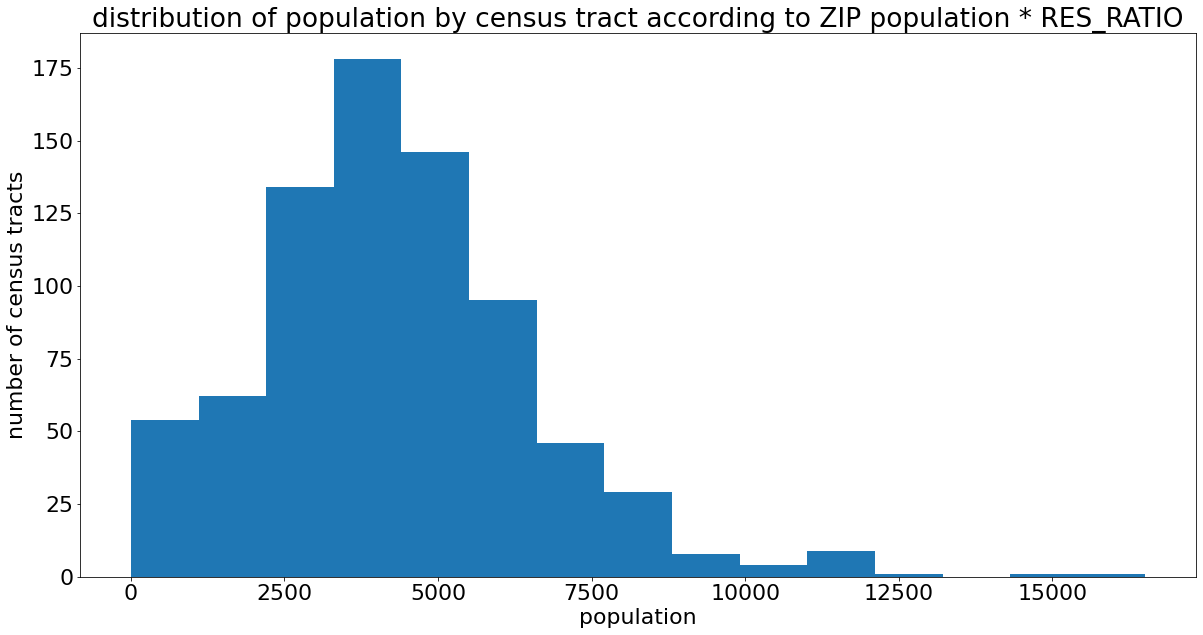

In [56]:
pops = [x[1] for x in census_tract_population_list]
plt.figure(figsize=(20, 10))
plt.hist(pops, bins=15)
plt.xlabel('population')
plt.ylabel('number of census tracts')
plt.title('distribution of population by census tract according to ZIP population * RES_RATIO')
plt.show()

In [57]:
different_population_df = pd.DataFrame(census_tract_population_list, columns=['ct_key', 'res_ratio_population'])

In [58]:
different_population_df.head()

,ct_key,res_ratio_population
0,8001007801,3956
1,8001007802,4480
2,8001007900,5853
3,8001008000,6393
4,8001008100,1294


In [59]:
# AGE AND SEX (2018: ACS 5-Year Estimates Subject Tables)
# https://data.census.gov/cedsci/table?t=Populations%20and%20People&g=0400000US08.140000&tid=ACSST5Y2018.S0101&hidePreview=false
age_demographics_df = read_in_dataset('age_demographics')
age_demographics_df.rename({'Estimate!!Total!!Total population': 'age_census_population'}, axis=1, inplace=True)
age_census_pop_df = age_demographics_df[['ct_key', 'age_census_population']]

In [60]:
different_population_df = different_population_df.merge(age_census_pop_df, on='ct_key', how='left')

In [61]:
different_population_df.head()

,ct_key,res_ratio_population,age_census_population
0,8001007801,3956,4137.0
1,8001007802,4480,4664.0
2,8001007900,5853,5684.0
3,8001008000,6393,6241.0
4,8001008100,1294,1525.0


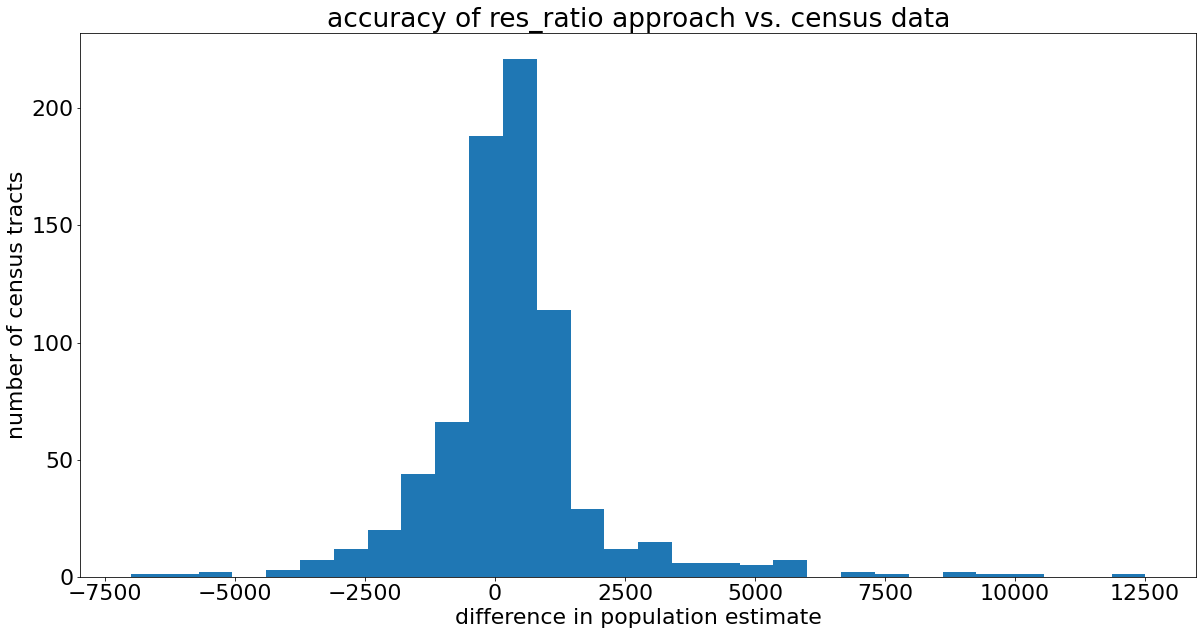

In [62]:
plt.figure(figsize=(20, 10))
plt.hist(different_population_df['age_census_population'] - different_population_df['res_ratio_population'],
         bins=30)
plt.xlabel('difference in population estimate')
plt.ylabel('number of census tracts')
plt.title('accuracy of res_ratio approach vs. census data')
plt.show()

In [63]:
# ACS demographic and housing estimates (2018: ACS 5-Year Estimates Data Profiles)
# (https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDP5Y2010.DP05&hidePreview=false)
racial_demographics_df = read_in_dataset('racial_demographics')
racial_demographics_df.rename({'Estimate!!RACE!!Total population': 'racial_census_population'}, 
                              axis=1, inplace=True)
racial_census_pop_df = racial_demographics_df[['ct_key', 'racial_census_population']]

In [64]:
different_population_df = different_population_df.merge(racial_census_pop_df, on='ct_key', how='left')

In [65]:
for _, row in different_population_df.iterrows():
    age_pop = row['age_census_population']
    race_pop = row['racial_census_population']
    if age_pop != race_pop:
        print(age_pop, race_pop)

nan nan


In [66]:
census_tracts_no_pop_df = different_population_df[(different_population_df['age_census_population'].isna()) |
                                                  (different_population_df['age_census_population'] == 0)]

In [67]:
census_tracts_no_pop_df

,ct_key,res_ratio_population,age_census_population,racial_census_population
96,8001988700,13,0.0,0.0
324,8014060100,0,NaN,NaN
325,8014980100,5,0.0,0.0
470,8031980100,2844,0.0,0.0
676,8059980000,0,0.0,0.0


In [68]:
census_tracts_no_pop = list(census_tracts_no_pop_df['ct_key'])

In [69]:
# ignore census tracts that have 0 population according to the Census Bureau
print(len(ct_stats_df))
ct_stats_df = ct_stats_df[~ct_stats_df['ct_key'].isin(census_tracts_no_pop)]
print(len(ct_stats_df))

767
763


In [70]:
# add population to the census tract level features
ct_stats_df = ct_stats_df.merge(different_population_df[['ct_key', 'age_census_population']], 
                                on='ct_key', how='left')

ct_stats_df.rename({'age_census_population': 'census_population'}, axis=1, inplace=True)
ct_stats_df['census_population'] = ct_stats_df['census_population'].astype(int)

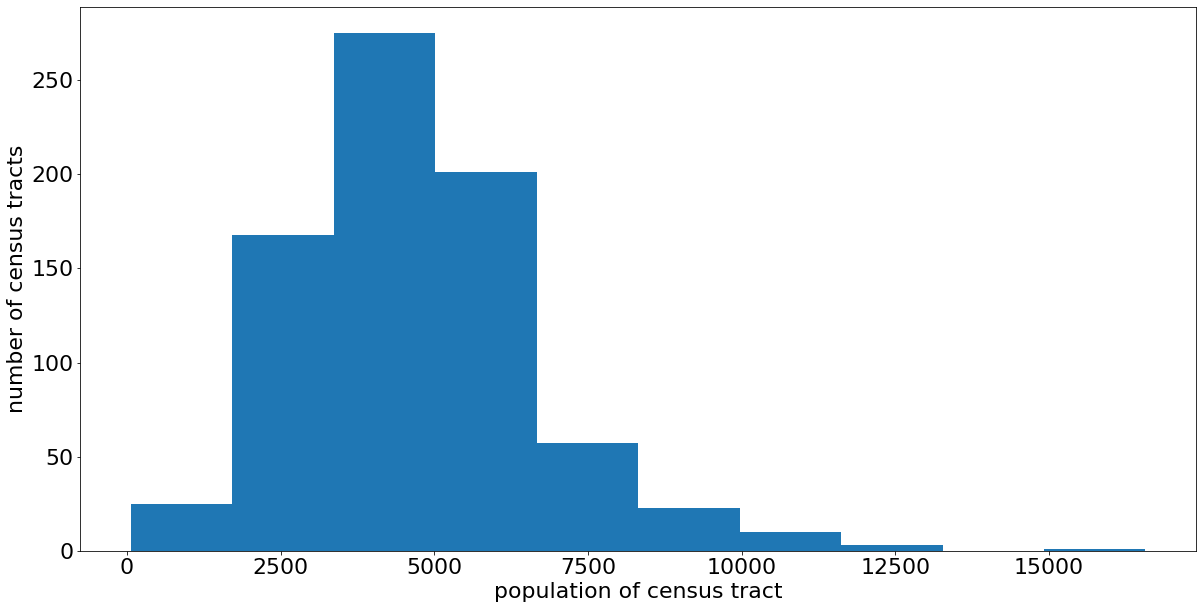

In [71]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df['census_population'])
plt.xlabel('population of census tract')
plt.ylabel('number of census tracts')
plt.show()

## Adding features from Census Bureau

### Age demographics

Age brackets:
1. < 18
2. 18-24
3. 25-34
4. 35-49
5. 50-59
6. 60-64
7. 65-74
8. 75+

In [72]:
age_demographics_df.head(2)

,ct_key,Geographic Area Name,age_census_population,Margin of Error!!Total MOE!!Total population,Estimate!!Percent!!Total population,Margin of Error!!Percent MOE!!Total population,Estimate!!Male!!Total population,Margin of Error!!Male MOE!!Total population,Estimate!!Percent Male!!Total population,Margin of Error!!Percent Male MOE!!Total population,Estimate!!Female!!Total population,Margin of Error!!Female MOE!!Total population,Estimate!!Percent Female!!Total population,Margin of Error!!Percent Female MOE!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent MOE!!Total population!!AGE!!Under 5 years,Estimate!!Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Male MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent Male MOE!

In [73]:
# age_group_to_column_endings = {'<18': ['Under 5', '5 to 9', '10 to 14', '15 to 17'],
#                                '18-24': ['18 and 19', '20', '21', '22 to 24'],
#                                '25-34': ['25 to 29', '30 to 34'],
#                                '35-49': ['35 to 39', '40 to 44', '45 to 49'],
#                                '50-59': ['50 to 54', '55 to 59'],
#                                '60-64': ['60 and 61', '62 to 64'],
#                                '65-74': ['65 and 66', '67 to 69', '70 to 74'],
#                                '75+': ['75 to 79', '80 to 84', '85 years and over']}

In [74]:
age_group_to_column_endings = {'<18': ['Under 18 years'],
                               '18-24': ['18 to 24'],
                               '25-34': ['25 to 29', '30 to 34'],
                               '35-49': ['35 to 39', '40 to 44', '45 to 49'],
                               '50-59': ['50 to 54', '55 to 59'],
                               '60-64': ['60 to 64'],
                               '65-74': ['65 to 69', '70 to 74'],
                               '75+': ['75 to 79', '80 to 84', '85 years and over']}

In [75]:
age_breakdown_df = pd.DataFrame(age_demographics_df['ct_key'])

In [76]:
for age_group, column_endings in age_group_to_column_endings.items():
    cnt_array = np.zeros(len(age_demographics_df))
    for column_ending in column_endings:
        relevant_column = [column for column in age_demographics_df.columns
                           if (column.startswith('Estimate!!Total') 
                               and column.split('!!')[-1].startswith(column_ending))][0]
        cnt_array += age_demographics_df[relevant_column]
    age_breakdown_df[age_group] = cnt_array / age_demographics_df['age_census_population']

In [77]:
age_breakdown_df.head()

,ct_key,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+
0,8001007801,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.021030
1,8001007802,0.286878,0.108276,0.164022,0.275515,0.082547,0.033662,0.032161,0.016938
2,8001007900,0.294159,0.107495,0.200915,0.250000,0.075123,0.033603,0.024982,0.013723
3,8001008000,0.331037,0.079474,0.173690,0.200449,0.094696,0.034289,0.065374,0.020990
4,8001008100,0.075410,0.177049,0.398689,0.155410,0.054426,0.021639,0.042623,0.074754


In [78]:
ct_stats_df = ct_stats_df.merge(age_breakdown_df, on='ct_key', how='left')

### Racial demographics

In [79]:
race_to_column_ending = {'Hispanic': 'Hispanic or Latino (of any race)',
                         'White': 'White alone',
                         'Black': 'Black or African American alone',
                         'Asian': 'Asian alone'}

In [80]:
racial_breakdown_df = pd.DataFrame(racial_demographics_df['ct_key'])

In [81]:
for race, column_ending in race_to_column_ending.items():
    relevant_column = [column for column in racial_demographics_df.columns
                       if column.startswith('Estimate') and column.split('!!')[-1] == column_ending][0]
    racial_breakdown_df[race] = (racial_demographics_df[relevant_column] / 
                                 racial_demographics_df['racial_census_population'])

In [82]:
racial_breakdown_df.head()

,ct_key,Hispanic,White,Black,Asian
0,8001007801,0.459753,0.147450,0.117718,0.239304
1,8001007802,0.569897,0.135077,0.182676,0.067753
2,8001007900,0.552076,0.226249,0.143737,0.020936
3,8001008000,0.521231,0.215350,0.143086,0.055119
4,8001008100,0.228197,0.578361,0.030820,0.097705


In [83]:
for race in race_to_column_ending:
    print(f'percentage of population in Colorado that is {race}:', 
          round(100 * np.mean(racial_breakdown_df[race]), 2))

percentage of population in Colorado that is Hispanic: 21.17
percentage of population in Colorado that is White: 69.2
percentage of population in Colorado that is Black: 3.52
percentage of population in Colorado that is Asian: 2.85


These numbers almost perfectly align with the demographic info here: https://en.wikipedia.org/wiki/Colorado#Demographics

In [84]:
ct_stats_df = ct_stats_df.merge(racial_breakdown_df, on='ct_key', how='left')

### Population growth

In [85]:
sorted_filenames = ['ACSST5Y' + str(year) + '.S0101_data_with_overlays_2020-10-18T043740.csv'
                    for year in range(2010, 2019)]

ct_key_to_population_trend = defaultdict(list)

age_demographics_directory = f'{data_dir}/age_demographics_2010_2018'
for f in sorted_filenames:
    df = pd.read_csv(f'{age_demographics_directory}/{f}', header=1)
    df = convert_to_ct_key(df)
    try:
        population_column = 'Total!!Estimate!!Total population'
        df = df[['ct_key', population_column]]
    except KeyError:
        population_column = 'Estimate!!Total!!Total population'
        df = df[['ct_key', population_column]]
    
    for _, row in df.iterrows():
        ct_key_to_population_trend[row['ct_key']].append(row[population_column])

In [86]:
denver_census_tracts = set(ct_stats_df['ct_key'])

In [87]:
lin_reg = LinearRegression()

# clip zipcodes that grow faster than an average of 10% per year
def calculate_growth_rate(population_trend, max_annual_growth=0.1):
    lin_reg.fit(np.arange(len(population_trend)).reshape(-1, 1), population_trend)
    slope = lin_reg.coef_[0] / population_trend[0]
    avg_yoy_change = np.mean([(population_trend[i + 1] - population_trend[i]) / population_trend[i] 
                               for i in range(len(population_trend) - 1)])
    
    return min(slope, max_annual_growth), min(avg_yoy_change, max_annual_growth)

In [88]:
population_growth_rate_lst = []
for ct_key, population_trend in ct_key_to_population_trend.items():
    if ct_key in denver_census_tracts:
        population_trend_last_5_years = population_trend[-5:]
        slope_9_yr, avg_yoy_change_9_yr = calculate_growth_rate(population_trend)
        slope_5_yr, avg_yoy_change_5_yr = calculate_growth_rate(population_trend_last_5_years)
        population_growth_rate_lst.append((ct_key, slope_9_yr, avg_yoy_change_9_yr, 
                                           slope_5_yr, avg_yoy_change_5_yr))

In [89]:
columns = ['ct_key', 'linear_pop_trend_since_2010', 'avg_annual_pop_change_since_2010',
           'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014']
ct_population_growth_df = pd.DataFrame(population_growth_rate_lst, columns=columns)

In [90]:
ct_population_growth_df.head()

,ct_key,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014
0,8013012607,0.038339,0.035680,0.038530,0.034176
1,8013012608,-0.003471,0.000506,-0.006932,-0.009388
2,8013012701,0.013204,0.015091,0.025325,0.022277
3,8013012705,0.025683,0.027038,0.040293,0.039040
4,8013012707,0.007119,0.013743,-0.003175,-0.009469


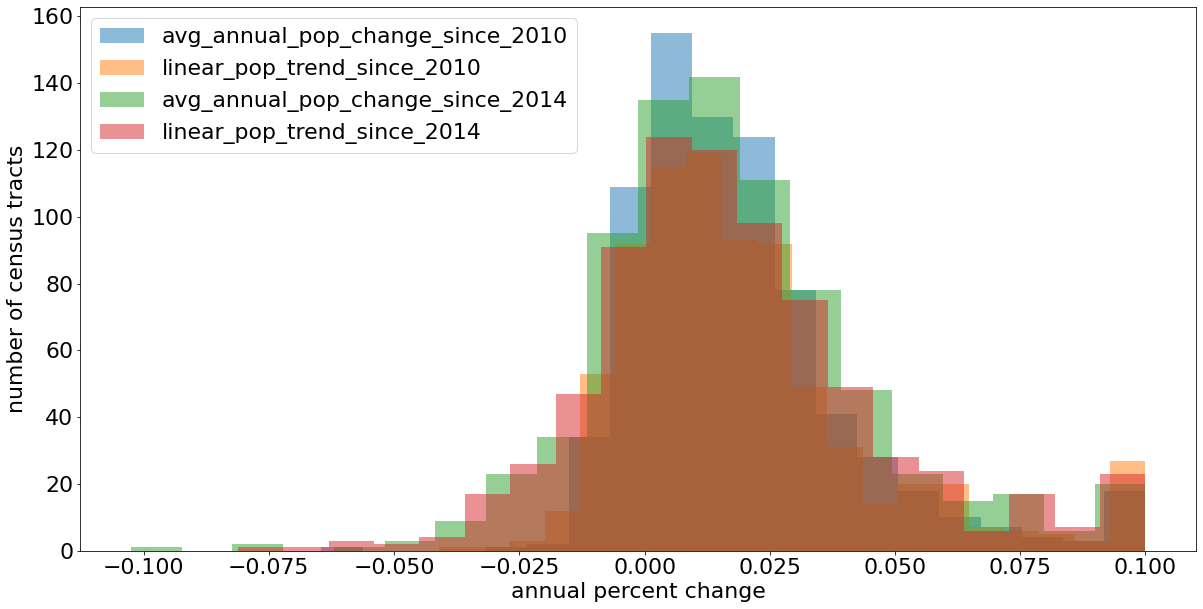

In [91]:
plt.figure(figsize=(20, 10))
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2010'], bins=20, alpha=0.5,
         label='avg_annual_pop_change_since_2010')
plt.hist(ct_population_growth_df['linear_pop_trend_since_2010'], bins=20, alpha=0.5,
         label='linear_pop_trend_since_2010')
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2014'], bins=20, alpha=0.5,
         label='avg_annual_pop_change_since_2014')
plt.hist(ct_population_growth_df['linear_pop_trend_since_2014'], bins=20, alpha=0.5,
         label='linear_pop_trend_since_2014')
plt.xlabel('annual percent change')
plt.ylabel('number of census tracts')
plt.legend()
plt.show()

In [92]:
ct_stats_df = ct_stats_df.merge(ct_population_growth_df, on='ct_key', how='left')

### Fertility

In [93]:
# Fertility 
# https://data.census.gov/cedsci/table?t=Fertility&g=0400000US08.140000&tid=ACSST5Y2018.S1301&hidePreview=false
fertility_df = read_in_dataset('fertility')
fertility_df.rename({'Estimate!!Women with births in the past 12 months!!Number!!Women 15 to 50 years': 
                     'number_of_births'}, axis=1, inplace=True)

In [94]:
fertility_df = fertility_df[['ct_key', 'number_of_births']]
fertility_df = fertility_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
fertility_df['annual_births_per_resident'] = fertility_df['number_of_births'] / fertility_df['census_population']

In [95]:
fertility_df.head()

,ct_key,number_of_births,census_population,annual_births_per_resident
0,8001007801,60,4137,0.014503
1,8001007802,59,4664,0.012650
2,8001007900,37,5684,0.006510
3,8001008000,104,6241,0.016664
4,8001008100,15,1525,0.009836


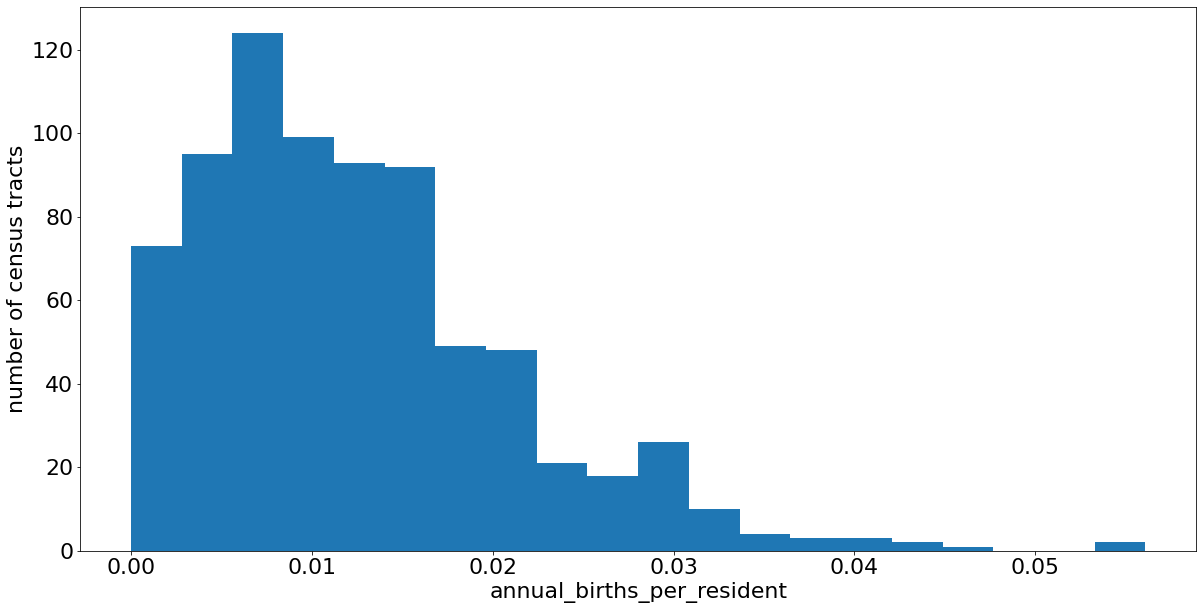

In [96]:
plt.figure(figsize=(20, 10))
plt.hist(fertility_df['annual_births_per_resident'], bins=20)
plt.xlabel('annual_births_per_resident')
plt.ylabel('number of census tracts')
plt.show()

In [97]:
ct_stats_df = ct_stats_df.merge(fertility_df[['ct_key', 'annual_births_per_resident']], on='ct_key', how='left')

### Commuting

In [98]:
# MEANS OF TRANSPORTATION TO WORK BY TENURE
# https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDT5Y2018.B08137&hidePreview=false
commuting_df = read_in_dataset('commuting_mode')
commuting_df.rename({'Estimate!!Total': 'workforce_size'}, axis=1, inplace=True)

In [99]:
commuting_df = commuting_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
commuting_df['workforce_fraction'] = commuting_df['workforce_size'] / commuting_df['census_population']
transit_mode_df = commuting_df[['ct_key', 'workforce_fraction']]

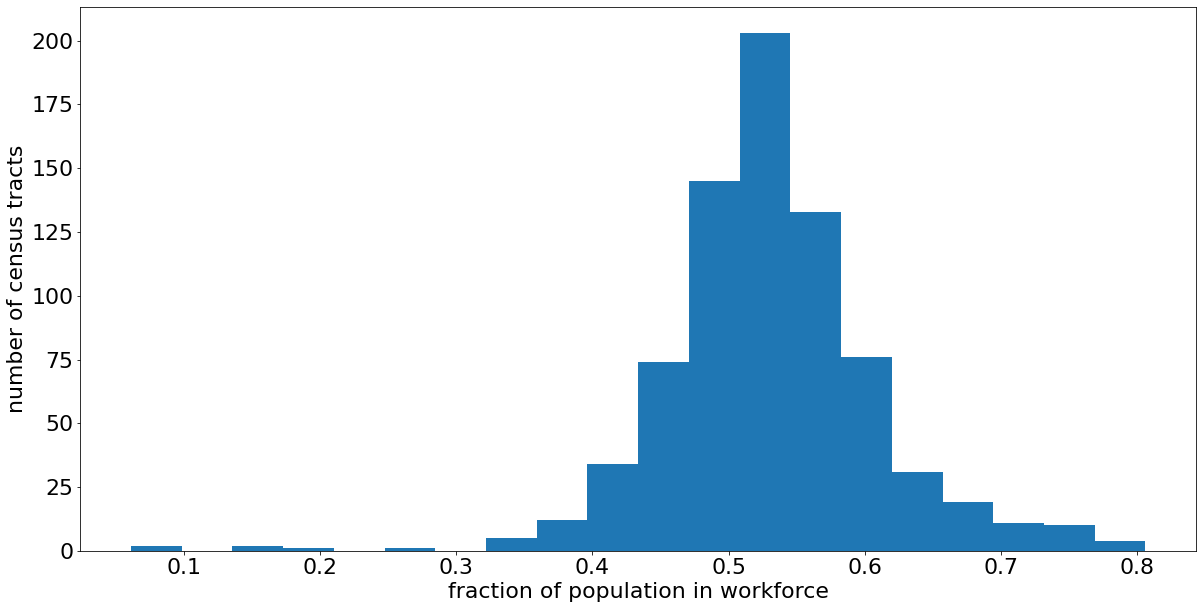

In [100]:
plt.figure(figsize=(20, 10))
plt.hist(transit_mode_df['workforce_fraction'], bins=20)
plt.xlabel('fraction of population in workforce')
plt.ylabel('number of census tracts')
plt.show()

In [101]:
transit_mode_to_column_ending = {'car': 'Car, truck, or van - drove alone', 
                                 'carpool': 'Car, truck, or van - carpooled',
                                 'public_transportation': 'Public transportation',
                                 'walk': 'Walked',
                                 'WFH': 'Worked at home',
                                 'other_mode_of_transit': 'Taxicab, motorcycle, bicycle'}

In [102]:
for transit_mode, column_ending in transit_mode_to_column_ending.items():
    relevant_column = [column for column in commuting_df.columns
                       if (column.startswith('Estimate!!Total') 
                           and column.split('!!')[-1].startswith(column_ending))][0]
    transit_mode_df[transit_mode] = commuting_df[relevant_column] / commuting_df['workforce_size']

In [103]:
transit_mode_df.head()

,ct_key,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit
0,8001007801,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714
1,8001007802,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227
2,8001007900,0.501407,0.675439,0.168421,0.090175,0.029825,0.016140,0.020000
3,8001008000,0.444160,0.733766,0.152597,0.078283,0.005411,0.021284,0.008658
4,8001008100,0.497049,0.564644,0.122691,0.010554,0.232190,0.043536,0.026385


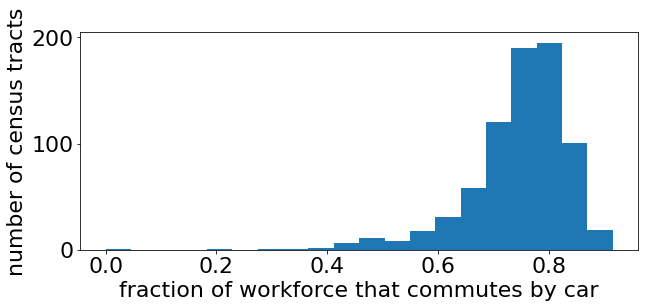

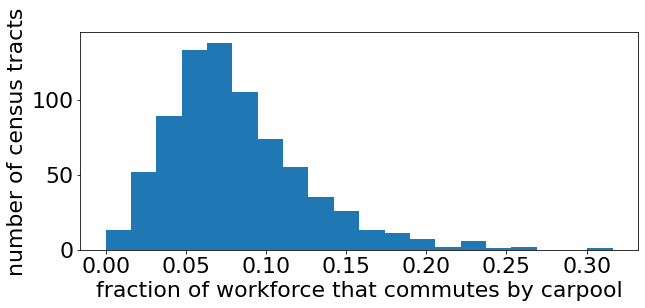

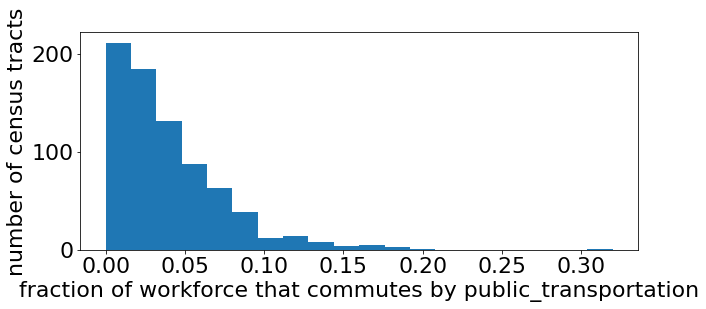

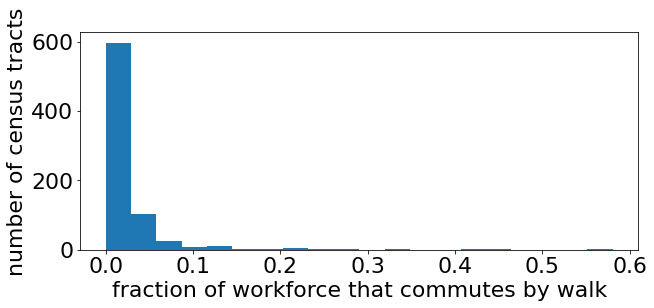

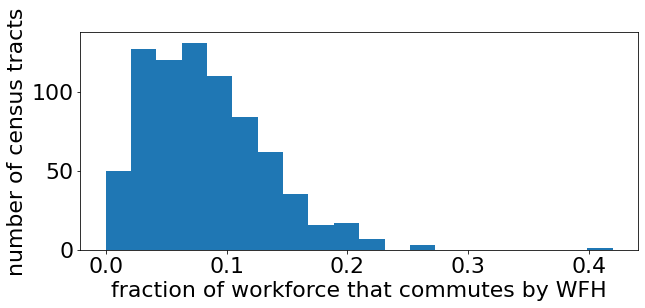

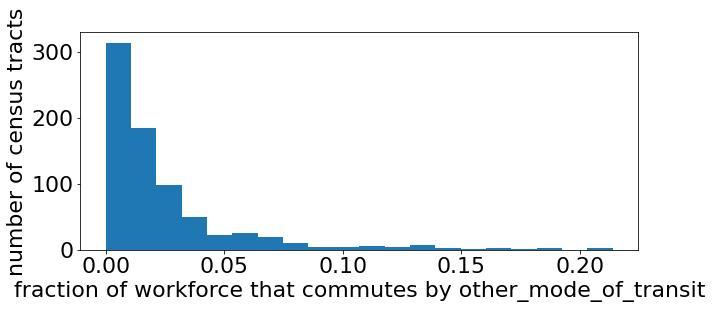

In [104]:
for transit_mode in transit_mode_to_column_ending:
    plt.figure(figsize=(10, 4))
    plt.hist(transit_mode_df[transit_mode], bins=20)
    plt.xlabel(f'fraction of workforce that commutes by {transit_mode}')
    plt.ylabel('number of census tracts')

In [105]:
ct_stats_df = ct_stats_df.merge(transit_mode_df, on='ct_key', how='left')

### Income

In [106]:
# INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29&g=0400000US08.140000&tid=ACSST5Y2018.S1901&hidePreview=false
income_df = read_in_dataset('income')
income_df = income_df[income_df['ct_key'].isin(denver_census_tracts)]

According to https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html

A household consists of all the people who occupy a housing unit. A house, an apartment or other group of rooms, or a single room, is regarded as a housing unit when it is occupied or intended for occupancy as separate living quarters; that is, when the occupants do not live with any other persons in the structure and there is direct access from the outside or through a common hall. 

A household includes the related family members and all the unrelated people, if any, such as lodgers, foster children, wards, or employees who share the housing unit. A person living alone in a housing unit, or a group of unrelated people sharing a housing unit such as partners or roomers, is also counted as a household. The count of households excludes group quarters. There are two major categories of households, "family" and "nonfamily". 

A family is a group of two people or more (one of whom is the householder) related by birth, marriage, or adoption and residing together; all such people (including related subfamily members) are considered as members of one family.

A nonfamily household consists of a householder living alone (a one-person household) or where the householder shares the home exclusively with people to whom he/she is not related.

In [107]:
column_to_new_column = {'Estimate!!Households!!Total': 'total_households',
                        'Estimate!!Families!!Total': 'total_families_households',
                        'Estimate!!Nonfamily households!!Total': 'total_nonfamily_households',
                        'Estimate!!Households!!Median income (dollars)': 'median_household_income',
                        'Estimate!!Families!!Median income (dollars)': 'median_family_income',
                        'Estimate!!Nonfamily households!!Median income (dollars)': 'median_nonfamily_income',
                        'Estimate!!Households!!Mean income (dollars)': 'mean_household_income',
                        'Estimate!!Families!!Mean income (dollars)': 'mean_family_income',
                        'Estimate!!Nonfamily households!!Mean income (dollars)': 'mean_nonfamily_income'}

In [108]:
income_df = income_df[['ct_key'] + list(column_to_new_column)]
income_df.rename(column_to_new_column, axis=1, inplace=True)

In [109]:
income_df['family_households_fraction'] = income_df['total_families_households'] / income_df['total_households']
income_df['nonfamily_households_fraction'] = (income_df['total_nonfamily_households'] / 
                                              income_df['total_households'])

income_df.drop(['total_households', 'total_families_households', 'total_nonfamily_households'], axis=1,
               inplace=True)

In [110]:
income_df.head(2)

,ct_key,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction
0,8001007801,32744,40921,19534,42004,49152,30554,0.595313,0.404687
1,8001007802,30598,31685,26144,41771,41349,39394,0.660900,0.339100


In [111]:
income_df[(income_df['median_family_income'] == '-') |
          (income_df['mean_nonfamily_income'] == 'N')]

,ct_key,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction
261,8013012202,38194,-,38491,56976,67830,54912,0.159760,0.840240
395,8031001902,125625,-,-,153220,159683,147932,0.450000,0.550000
403,8031002701,41957,-,40933,53589,97217,48127,0.111266,0.888734
983,8069002803,47500,-,47500,49611,-,49611,0.000000,1.000000
1228,8123002017,145938,145938,-,175672,175994,N,0.963134,0.036866


In [112]:
income_df.replace(to_replace='250,000+', value='250000', inplace=True)

In [113]:
for summary_stat in ['median', 'mean']:
    for family_type in ['family', 'nonfamily']:
        income_df[f'{summary_stat}_{family_type}_income'] = (
            income_df.apply(lambda x: x[f'{summary_stat}_household_income']
            if x[f'{summary_stat}_{family_type}_income'] in {'-', 'N'} 
            else x[f'{summary_stat}_{family_type}_income'], axis=1))

In [114]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        income_df[column] = income_df[column].astype(int)

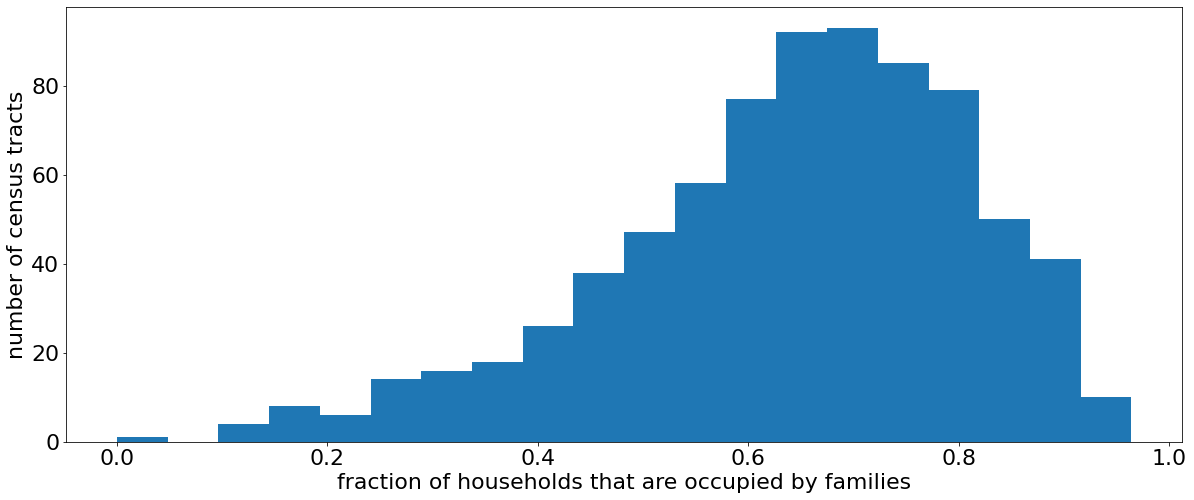

In [115]:
plt.figure(figsize=(20, 8))
plt.hist(income_df['family_households_fraction'], bins=20)
plt.xlabel('fraction of households that are occupied by families')
plt.ylabel('number of census tracts')
plt.show()

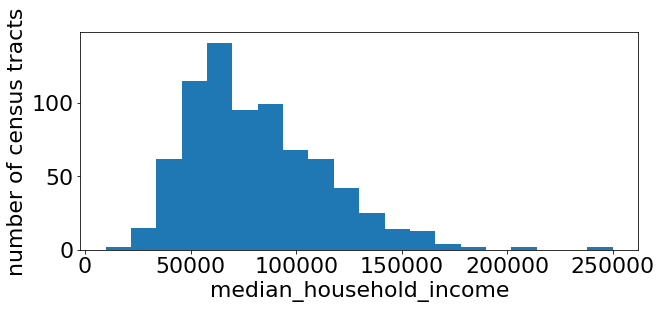

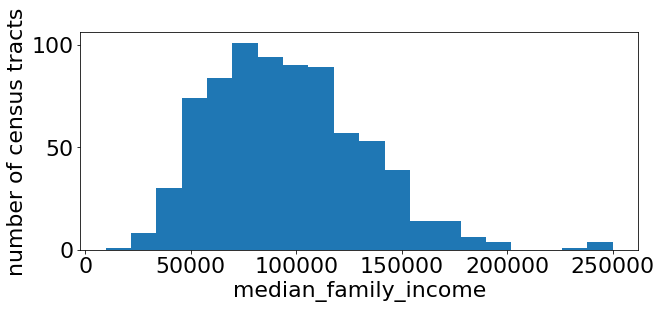

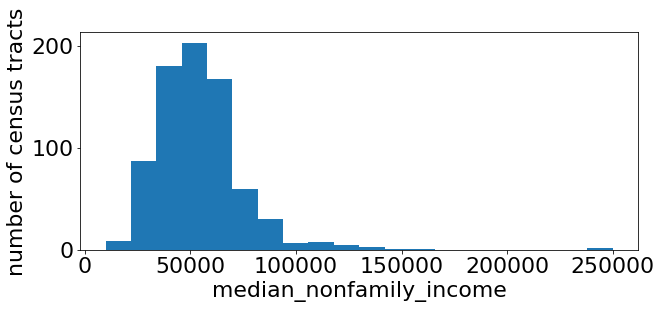

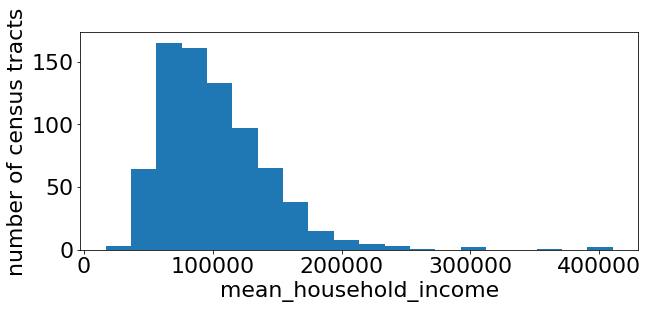

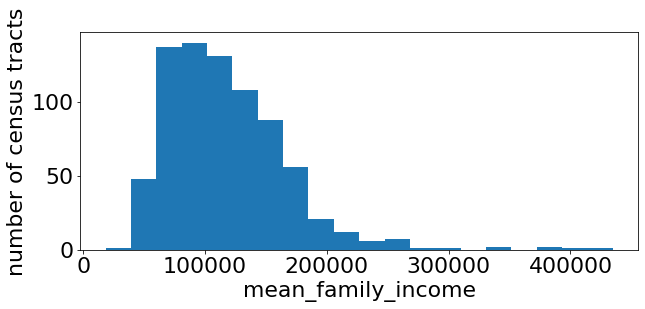

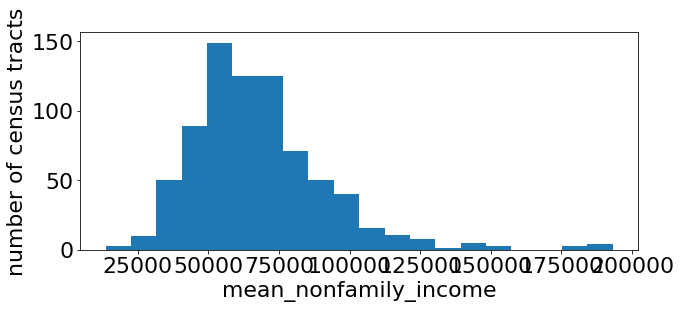

In [116]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        plt.figure(figsize=(10, 4))
        plt.hist(income_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('number of census tracts')
        plt.show()

In [117]:
ct_stats_df = ct_stats_df.merge(income_df, on='ct_key', how='left')

### Poverty

In [118]:
# FOOD STAMPS/SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM (SNAP)
# https://data.census.gov/cedsci/table?t=SNAP%2FFood%20Stamps&g=0400000US08.140000&tid=ACSST5Y2018.S2201&hidePreview=false
food_stamps_df = read_in_dataset('food_stamps')
food_stamps_df = food_stamps_df[food_stamps_df['ct_key'].isin(denver_census_tracts)]

In [119]:
column_to_new_column = {
    'Estimate!!Percent!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!At or above poverty level': 'above_poverty_line',
    'Estimate!!Percent households not receiving food stamps/SNAP!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!Below poverty level': 'below_poverty_line'
}

In [120]:
poverty_df = food_stamps_df[['ct_key'] + list(column_to_new_column)]
poverty_df.rename(column_to_new_column, axis=1, inplace=True)

In [121]:
poverty_df.head()

,ct_key,above_poverty_line,below_poverty_line
0,8001007801,75.1,20.6
1,8001007802,70.3,20.2
2,8001007900,81.4,11.4
3,8001008000,84,10.1
4,8001008100,74.1,23.7


In [122]:
for column in ['above_poverty_line', 'below_poverty_line']:
    poverty_df[column] = poverty_df[column].astype(float)

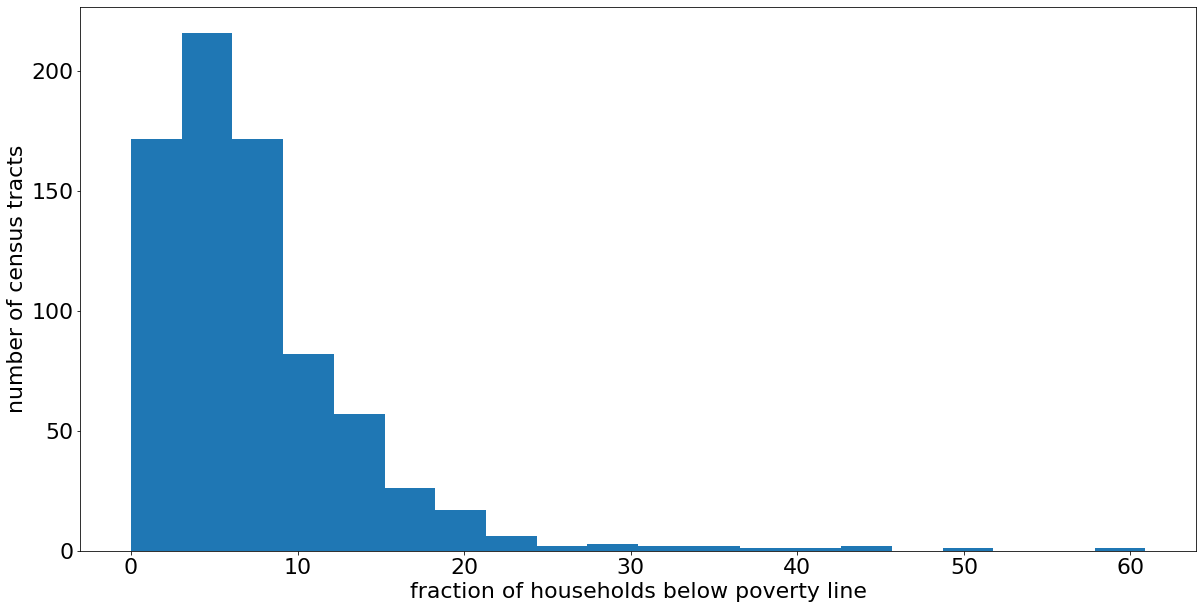

In [123]:
plt.figure(figsize=(20, 10))
plt.hist(poverty_df['below_poverty_line'], bins=20)
plt.xlabel('fraction of households below poverty line')
plt.ylabel('number of census tracts')
plt.show()

In [124]:
ct_stats_df = ct_stats_df.merge(poverty_df, on='ct_key', how='left')

### Occupation

In [125]:
# SELECTED ECONOMIC CHARACTERISTICS
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29%3APoverty&g=0400000US08.140000&tid=ACSDP5Y2018.DP03&hidePreview=false
economic_df = read_in_dataset('economic_characteristics')
economic_df = economic_df[economic_df['ct_key'].isin(denver_census_tracts)]

In [126]:
column_to_new_column = {
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services': 'STEM_jobs',
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance': 'education&health_care'
}

In [127]:
occupation_df = economic_df[['ct_key'] + list(column_to_new_column)]
occupation_df.rename(column_to_new_column, axis=1, inplace=True)

In [128]:
occupation_df.head()

,ct_key,STEM_jobs,education&health_care
0,8001007801,17.2,8.7
1,8001007802,16.6,6.1
2,8001007900,10.2,13.7
3,8001008000,17.8,14.2
4,8001008100,13.8,38.4


In [129]:
for column in ['STEM_jobs', 'education&health_care']:
    occupation_df[column] = occupation_df[column].astype(float)

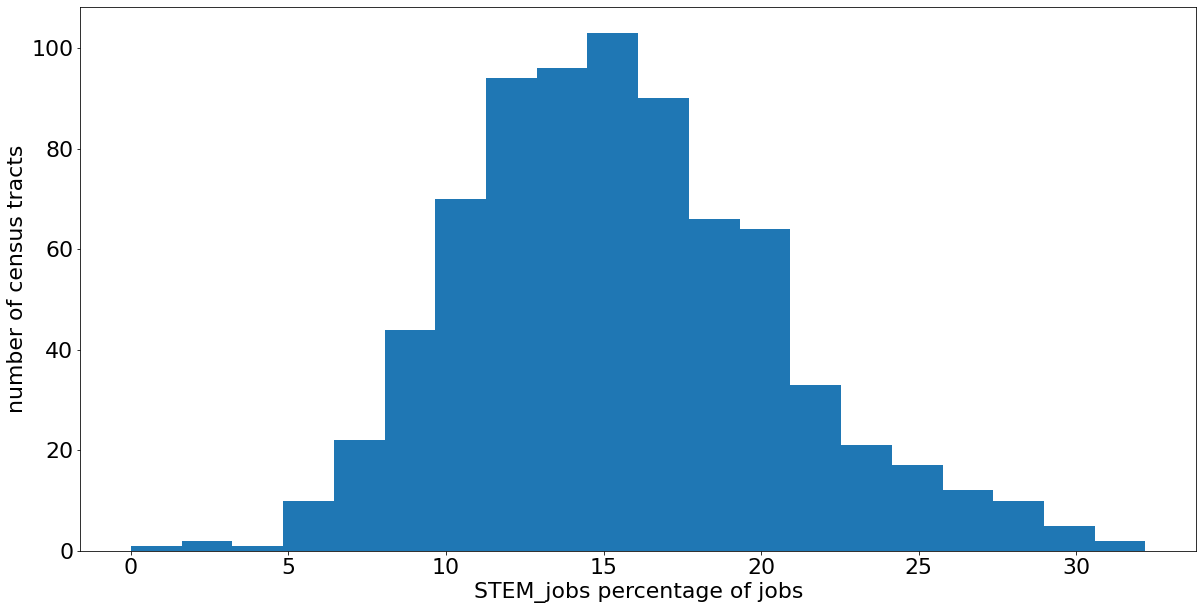

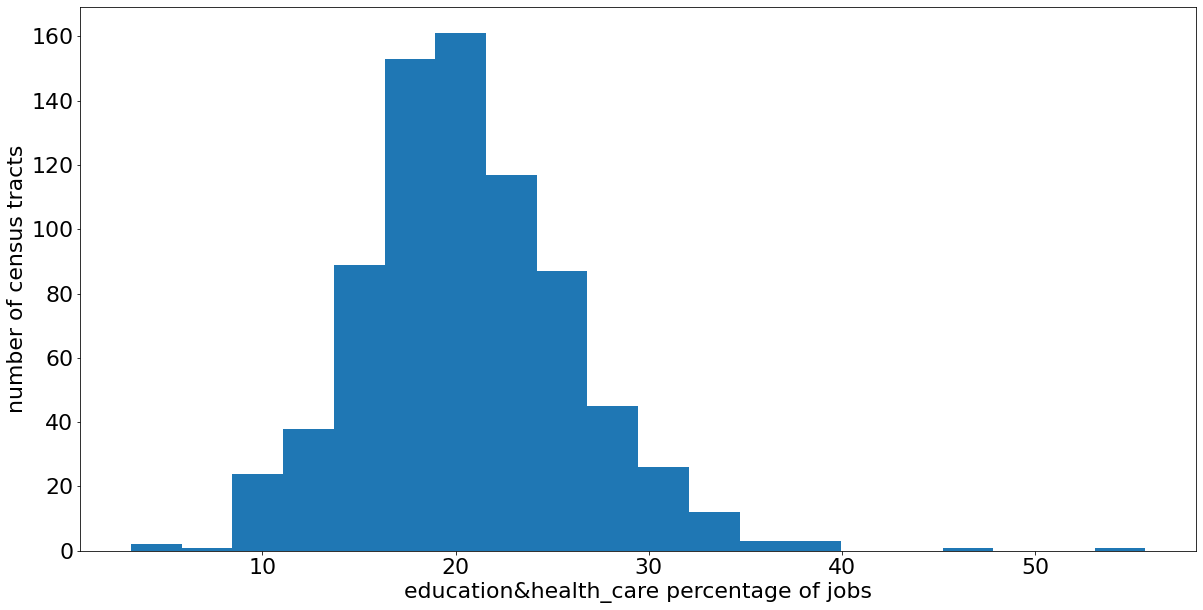

In [130]:
for column in ['STEM_jobs', 'education&health_care']:
    plt.figure(figsize=(20, 10))
    plt.hist(occupation_df[column], bins=20)
    plt.xlabel(column + ' percentage of jobs')
    plt.ylabel('number of census tracts')
    plt.show()

In [131]:
ct_stats_df = ct_stats_df.merge(occupation_df, on='ct_key', how='left')

### Household size

In [132]:
# HOUSEHOLDS AND FAMILIES
children_df = read_in_dataset('household_size')
children_df = children_df[children_df['ct_key'].isin(denver_census_tracts)]

In [133]:
column_to_new_column = {
    'Estimate!!Total!!HOUSEHOLDS!!Total households': 'total_households',
    'Estimate!!Total!!FAMILIES!!Average family size': 'avg_family_size',
    'Estimate!!Married-couple family household!!HOUSEHOLDS!!Average household size': 'avg_married_family_size',
    'Estimate!!Nonfamily household!!HOUSEHOLDS!!Average household size': 'avg_nonfamily_size',
    'Estimate!!Total!!HOUSEHOLDS!!Average household size': 'avg_household_size'
}

In [134]:
household_size_df = children_df[['ct_key'] + list(column_to_new_column)]
household_size_df.rename(column_to_new_column, axis=1, inplace=True)

In [135]:
household_size_df[(household_size_df['avg_family_size'] == '-') | 
                  (household_size_df['avg_married_family_size'] == '-') |
                  (household_size_df['avg_nonfamily_size'] == '-') |
                  (household_size_df['avg_household_size'] == '-')]

,ct_key,total_households,avg_family_size,avg_married_family_size,avg_nonfamily_size,avg_household_size
941,8069001114,875,2.76,2.79,-,2.6
983,8069002803,36,-,-,-,-
1217,8123002006,95,2.9,3.33,-,2.48
1228,8123002017,217,2.96,3.02,-,2.88


In [136]:
for idx, row in household_size_df.iterrows():
    for column in ['avg_family_size', 'avg_married_family_size', 'avg_household_size']:
        if row[column] == '-':
            mean_val = np.mean([float(x) for x in household_size_df[column] if x != '-'])
            household_size_df.loc[idx, column] = mean_val
        if row['avg_nonfamily_size'] == '-':
            try:
                impute_val = 2 * float(row['avg_household_size']) - float(row['avg_family_size'])
            except ValueError:
                mean_avg_household_size = np.mean([float(x) for x in household_size_df['avg_household_size']
                                                   if x != '-'])
                mean_avg_family_size = np.mean([float(x) for x in household_size_df['avg_family_size']
                                                    if x != '-'])
                impute_val = 2 * mean_avg_household_size - mean_avg_family_size
            household_size_df.loc[idx, 'avg_nonfamily_size'] = impute_val

In [137]:
for column in list(column_to_new_column.values())[1:]:
    household_size_df[column] = household_size_df[column].astype(float)

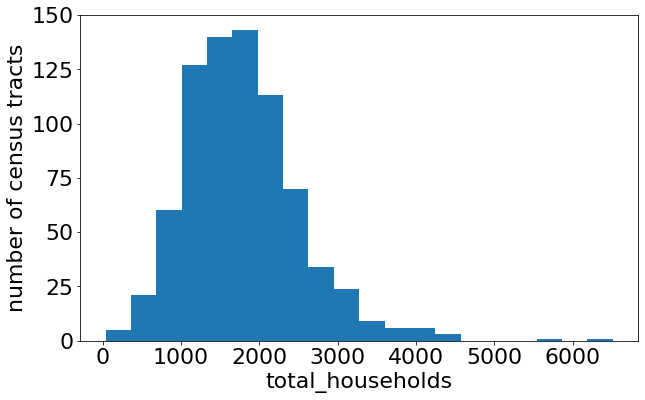

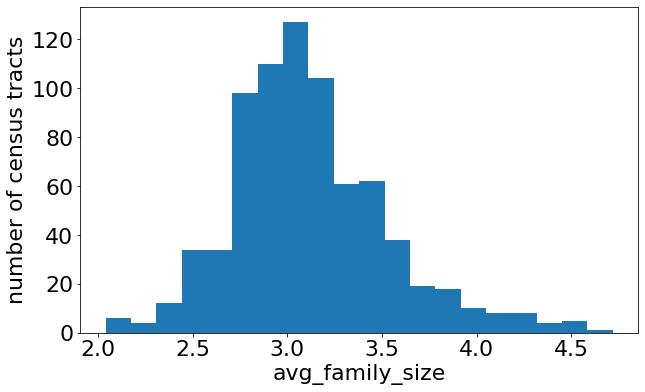

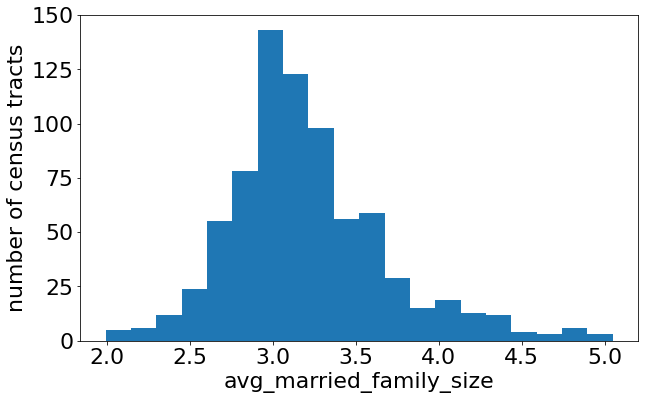

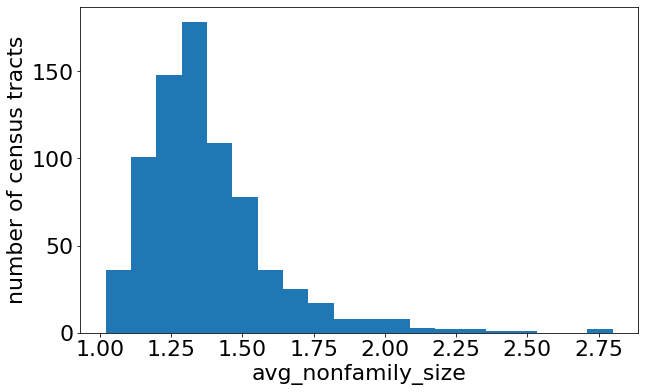

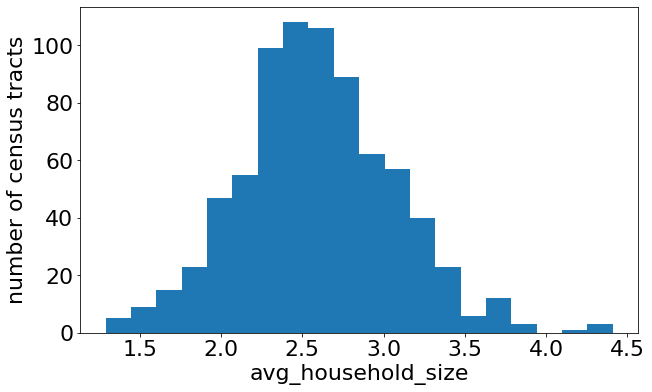

In [138]:
for column in household_size_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(10, 6))
        plt.hist(household_size_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('number of census tracts')
        plt.show()

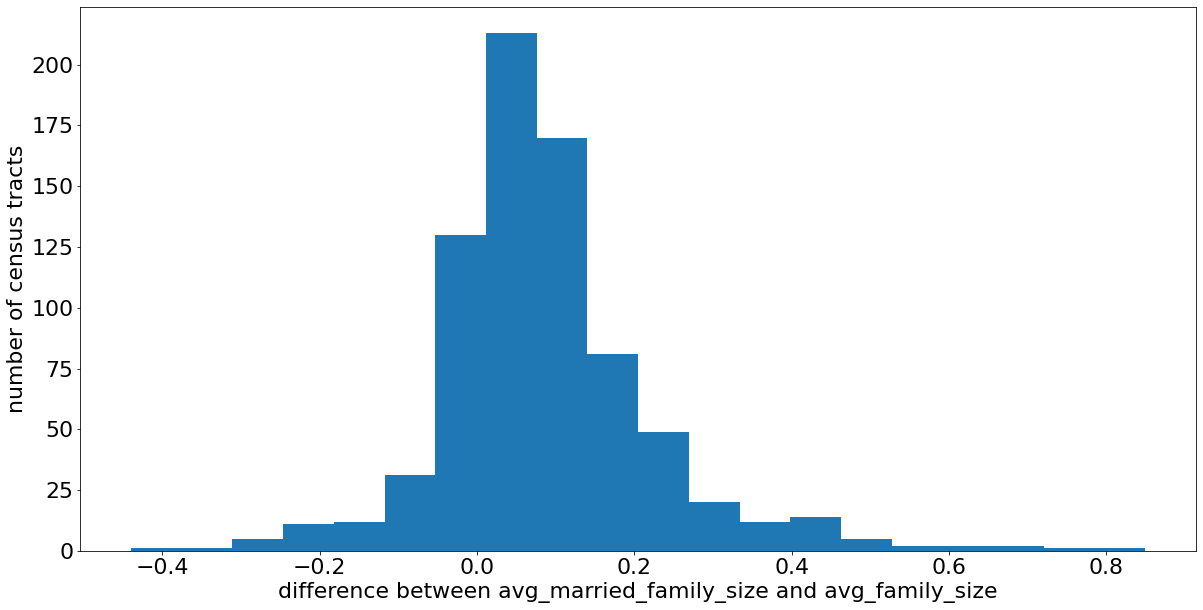

In [139]:
plt.figure(figsize=(20, 10))
plt.hist(household_size_df['avg_married_family_size'] - household_size_df['avg_family_size'], bins=20)
plt.xlabel('difference between avg_married_family_size and avg_family_size')
plt.ylabel('number of census tracts')
plt.show()

In [140]:
household_size_df.drop('avg_married_family_size', axis=1, inplace=True, errors='ignore')

In [141]:
ct_stats_df = ct_stats_df.merge(household_size_df, on='ct_key', how='left')

### Home Value

In [142]:
# VALUE (2018: ACS 5-Year Estimates Detailed Tables)
# https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDT5Y2018.B25075&hidePreview=false
valuation_df = read_in_dataset('house_value')
valuation_df = valuation_df[valuation_df['ct_key'].isin(denver_census_tracts)]

Home price brackets:
1. `<200k`
2. `200-300k`
3. `300-400k`
3. `400-500k`
4. `500-750k`
5. `750k-1000k`
6. `>1M`

In [143]:
value_bracket_to_column_endings = {
    '<200k': ['$80,000 to $89,999', '$90,000 to $99,999', '$100,000 to $124,999', '$125,000 to $149,999',
              '$150,000 to $174,999', '$175,000 to $199,999'],
    '200-300k': ['$200,000 to $249,999', '$250,000 to $299,999'],
    '300-400k': ['$300,000 to $399,999'],
    '400-500k': ['$400,000 to $499,999'],
    '500-750k': ['$500,000 to $749,999'],
    '750-1000k': ['$750,000 to $999,999'],
    '>1M': ['$1,000,000 to $1,499,999', '$1,500,000 to $1,999,999', '$2,000,000 or more']
}

In [144]:
valuation_breakdown_df = pd.DataFrame(valuation_df['ct_key'])

In [145]:
columns_to_subtract = ['Less than $10,000', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999',
                       '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $49,999',
                       '$50,000 to $59,999', '$60,000 to $69,999', '$70,000 to $79,999']
total_homes = np.array(valuation_df['Estimate!!Total'])
for column in columns_to_subtract:
    total_homes -= np.array(valuation_df['Estimate!!Total!!' + column])
    
valuation_breakdown_df['total_homes'] = total_homes

In [146]:
for value_bracket, column_endings in value_bracket_to_column_endings.items():
    cnt_array = np.zeros(len(valuation_breakdown_df))
    for column_ending in column_endings:
        relevant_column = [column for column in valuation_df.columns
                           if column == 'Estimate!!Total!!' + column_ending][0]
        cnt_array += valuation_df[relevant_column]
    valuation_breakdown_df[value_bracket] = cnt_array / valuation_breakdown_df['total_homes']

In [147]:
valuation_breakdown_df.head() 

,ct_key,total_homes,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M
5,8031000201,1035,0.235749,0.470531,0.216425,0.045411,0.015459,0.004831,0.011594
6,8031000600,411,0.000000,0.177616,0.128954,0.199513,0.413625,0.080292,0.000000
7,8031000800,53,0.566038,0.000000,0.169811,0.000000,0.264151,0.000000,0.000000
8,8031000902,1178,0.363328,0.445671,0.145161,0.022071,0.014431,0.000000,0.009338
9,8031000903,944,0.600636,0.206568,0.128178,0.010593,0.047669,0.000000,0.006356


In [148]:
np.quantile(valuation_breakdown_df['total_homes'], [0.01, 0.03, 0.05])

array([ 36.34, 204.72, 285.3 ])

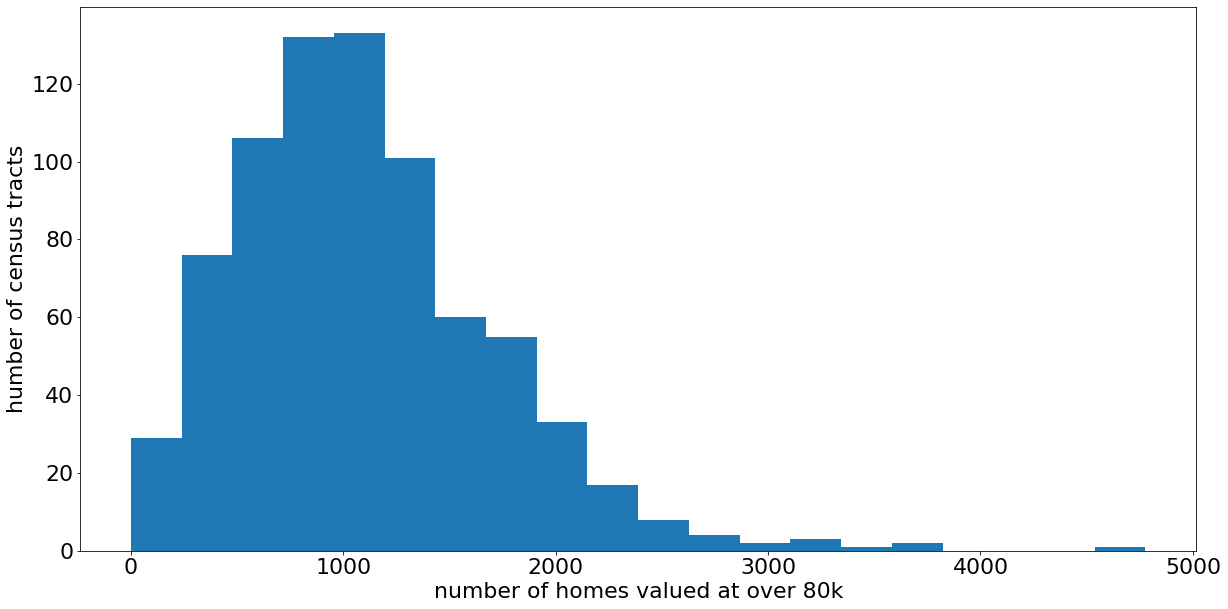

In [149]:
plt.figure(figsize=(20, 10))
plt.hist(valuation_breakdown_df['total_homes'], bins=20)
plt.xlabel('number of homes valued at over 80k')
plt.ylabel('humber of census tracts')
plt.show()

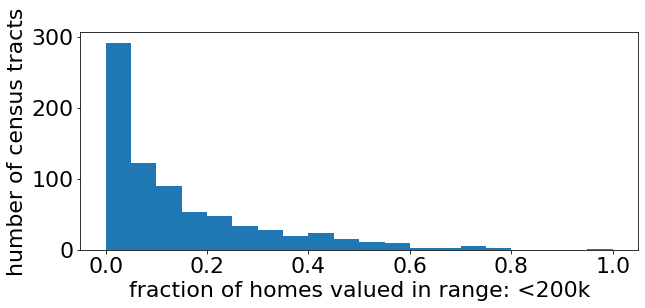

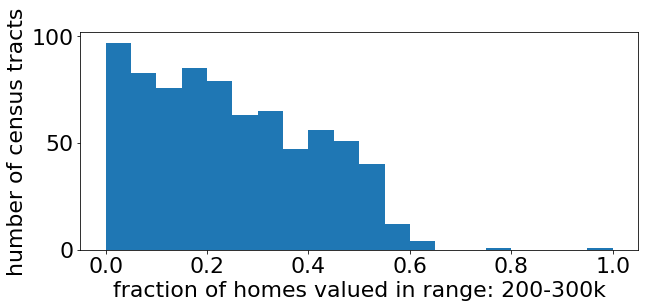

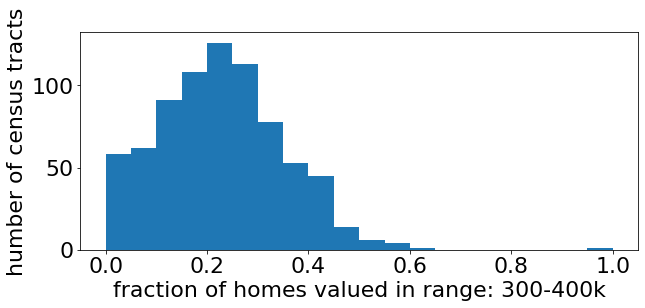

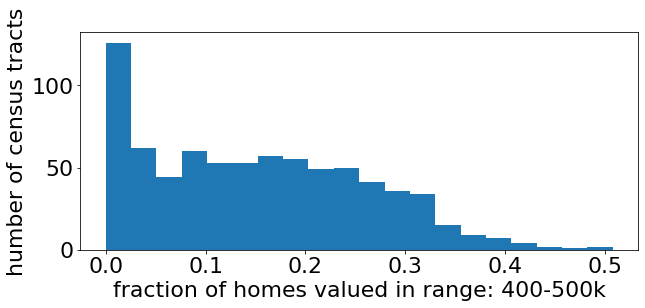

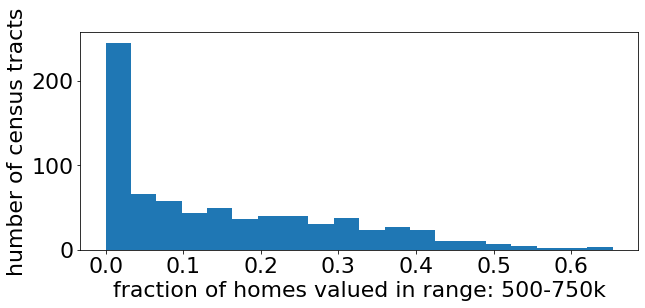

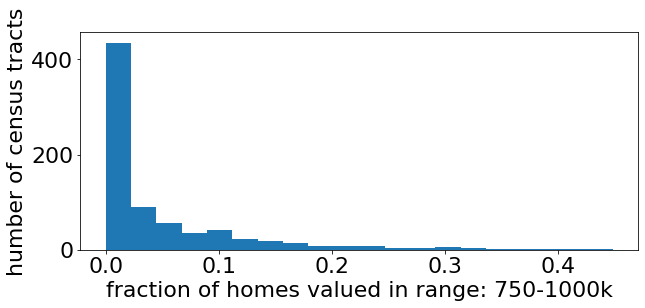

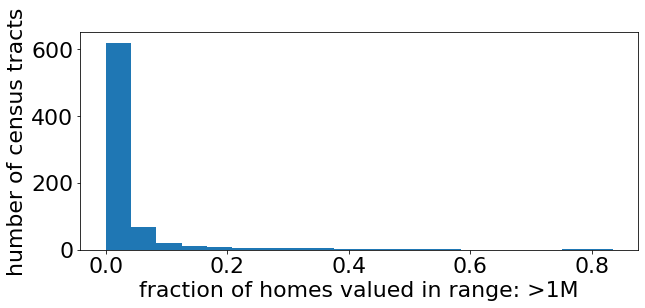

In [150]:
for column in valuation_breakdown_df.columns:
    if column not in {'ct_key', 'total_homes'}:
        plt.figure(figsize=(10, 4))
        plt.hist(valuation_breakdown_df[column], bins=20)
        plt.xlabel(f'fraction of homes valued in range: {column}')
        plt.ylabel('humber of census tracts')
        plt.show()

In [151]:
valuation_breakdown_df[valuation_breakdown_df['total_homes'] < 100]

,ct_key,total_homes,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M
7,8031000800,53,0.566038,0.000000,0.169811,0.000000,0.264151,0.00000,0.000000
133,8031001902,32,0.000000,0.250000,0.000000,0.218750,0.343750,0.09375,0.093750
260,8069000600,31,0.000000,0.580645,0.225806,0.000000,0.193548,0.00000,0.000000
462,8031007006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,8123002006,71,0.000000,0.126761,0.619718,0.070423,0.056338,0.00000,0.126761
556,8005004952,39,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000
575,8001008100,7,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
606,8005006713,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,8069002803,5,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
817,8013012300,14,0.500000,0.000000,0.000000,0.285714,0.214286,0.00000,0.000000


In [152]:
valuation_breakdown_df.drop('total_homes', axis=1, inplace=True, errors='ignore')
ct_stats_df = ct_stats_df.merge(valuation_breakdown_df, on='ct_key', how='left')

### Marital Status

In [153]:
# MARITAL STATUS
marital_status_df = read_in_dataset('marital_status')
marital_status_df = marital_status_df[marital_status_df['ct_key'].isin(denver_census_tracts)]

In [154]:
relationship_status_to_categories = {'married': ['Now married'],
                                     'divorced/separated/widowed': ['Widowed', 'Divorced', 'Separated'],
                                     'never_married': ['Never married']}

In [155]:
relationship_status_df = pd.DataFrame(marital_status_df['ct_key'])

In [156]:
for relationship_status, categories in relationship_status_to_categories.items():
    percent_array = np.zeros(len(relationship_status_df))
    for category in categories:
        relevant_column = [column for column in marital_status_df.columns
                           if column.startswith('Estimate!!' + category)][0]
        percent_array += marital_status_df[relevant_column].astype(float)
    relationship_status_df[relationship_status] = percent_array 

In [157]:
relationship_status_df.head()

,ct_key,married,divorced/separated/widowed,never_married
0,8001007801,33.7,22.8,43.5
1,8001007802,34.1,16.1,49.8
2,8001007900,38.7,14.9,46.5
3,8001008000,43.6,18.4,37.9
4,8001008100,30.8,17.1,52.1


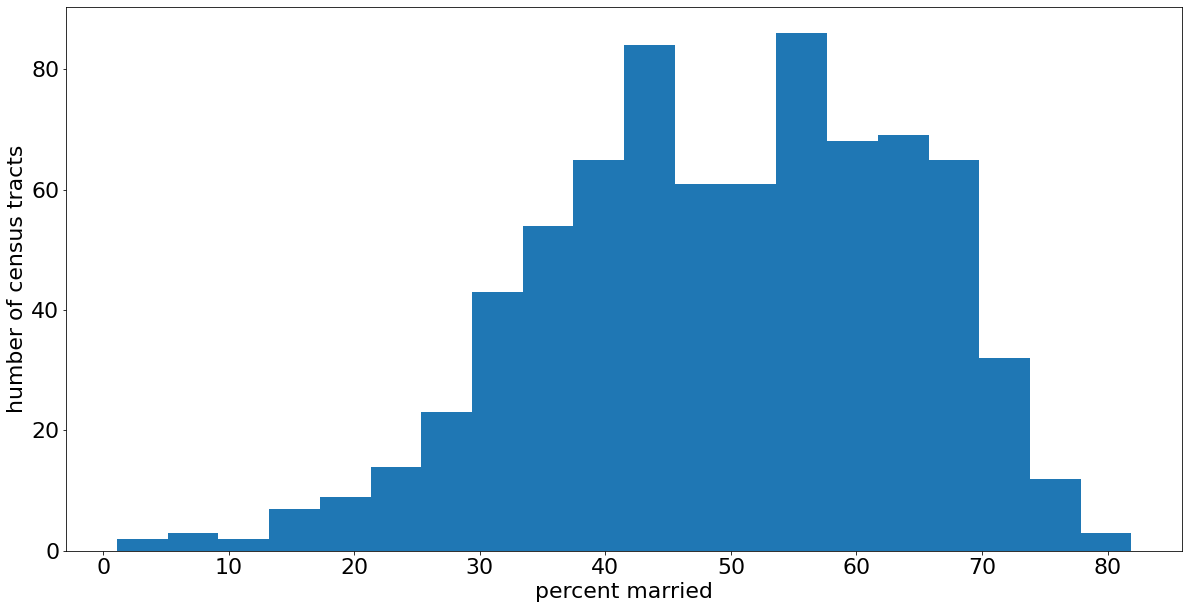

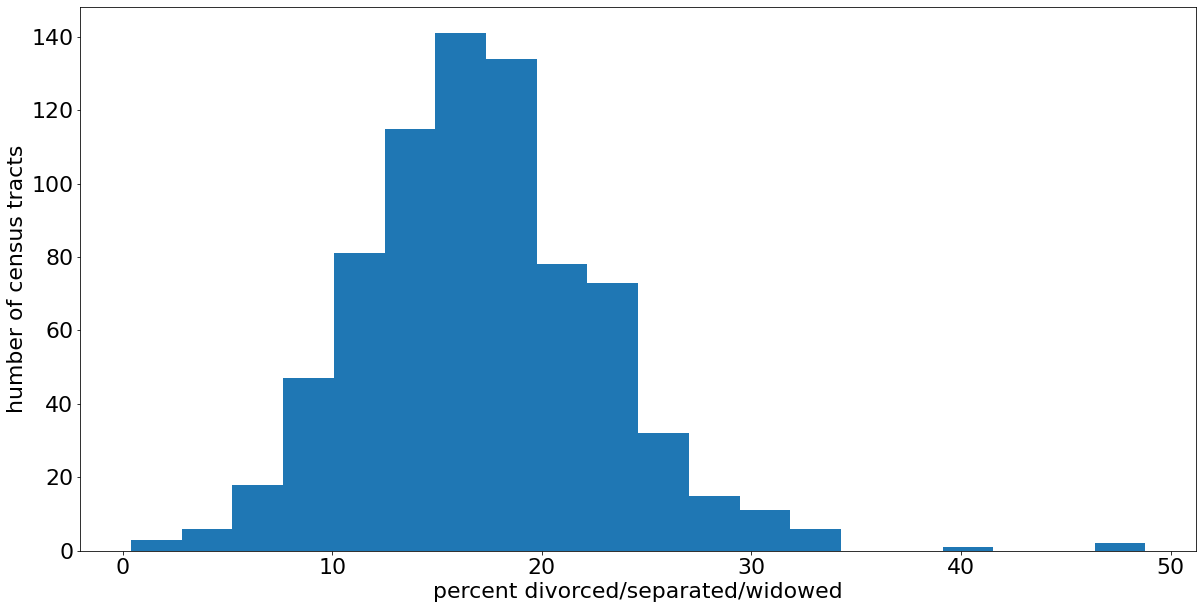

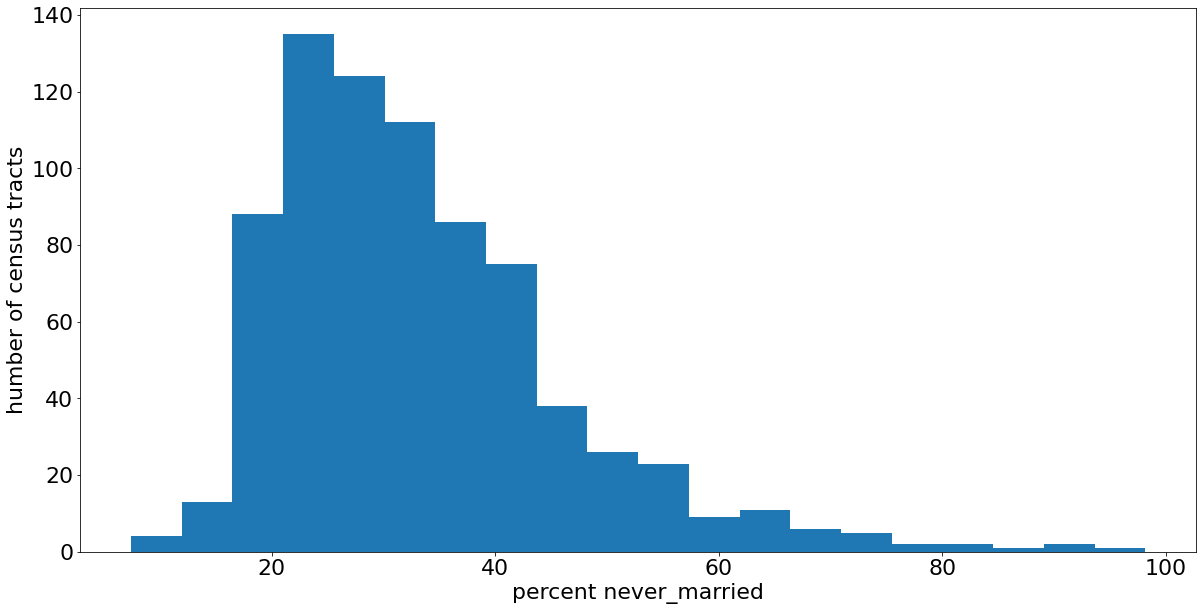

In [158]:
for column in relationship_status_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(relationship_status_df[column], bins=20)
        plt.xlabel(f'percent {column}')
        plt.ylabel('humber of census tracts')
        plt.show()

In [159]:
ct_stats_df = ct_stats_df.merge(relationship_status_df, on='ct_key', how='left')

### Mortgage

In [160]:
# MORTGAGE STATUS
# https://data.census.gov/cedsci/table?q=ACSDT1Y2019.B25081&g=0400000US08.140000&tid=ACSDT5Y2018.B25081&hidePreview=true
mortgage_status_df = read_in_dataset('mortgage_status')
mortgage_status_df = mortgage_status_df[mortgage_status_df['ct_key'].isin(denver_census_tracts)]

In [161]:
mortgage_status_df.head(2)

,ct_key,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,"Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Margin of Error!!Total!!Housing units without a mortgage
5,8031000201,"Census Tract 2.01, Denver County, Colorado",1068,109,848,109,136,76,57,41,79,61,0,12,712,103,220,67
6,8031000600,"Census Tract 6, Denver County, Colorado",411,91,319,81,75,38,38,30,37,28,0,12,244,80,92,52


In [162]:
column_to_new_column = {
    'Estimate!!Total': 'house_num',
    'Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt': 'mortgage_num',
    'Estimate!!Total!!Housing units without a mortgage': 'no_mortgage_num'
}

In [163]:
mortgage_info_df = mortgage_status_df[['ct_key'] + list(column_to_new_column)]
mortgage_info_df.rename(column_to_new_column, axis=1, inplace=True)

In [164]:
for column in ['mortgage_num', 'no_mortgage_num']:
    new_column = 'percent_' + '_'.join(column.split('_')[:-1])
    mortgage_info_df[new_column] = mortgage_info_df[column] / mortgage_info_df['house_num']

mortgage_info_df.drop(column_to_new_column.values(), axis=1, inplace=True, errors='ignore')

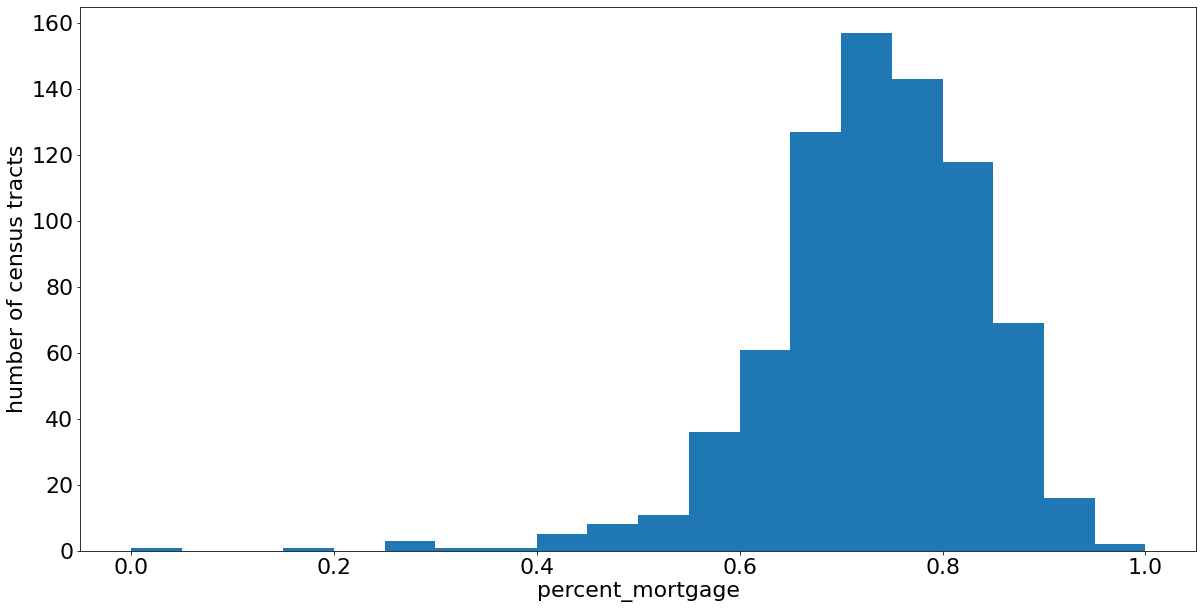

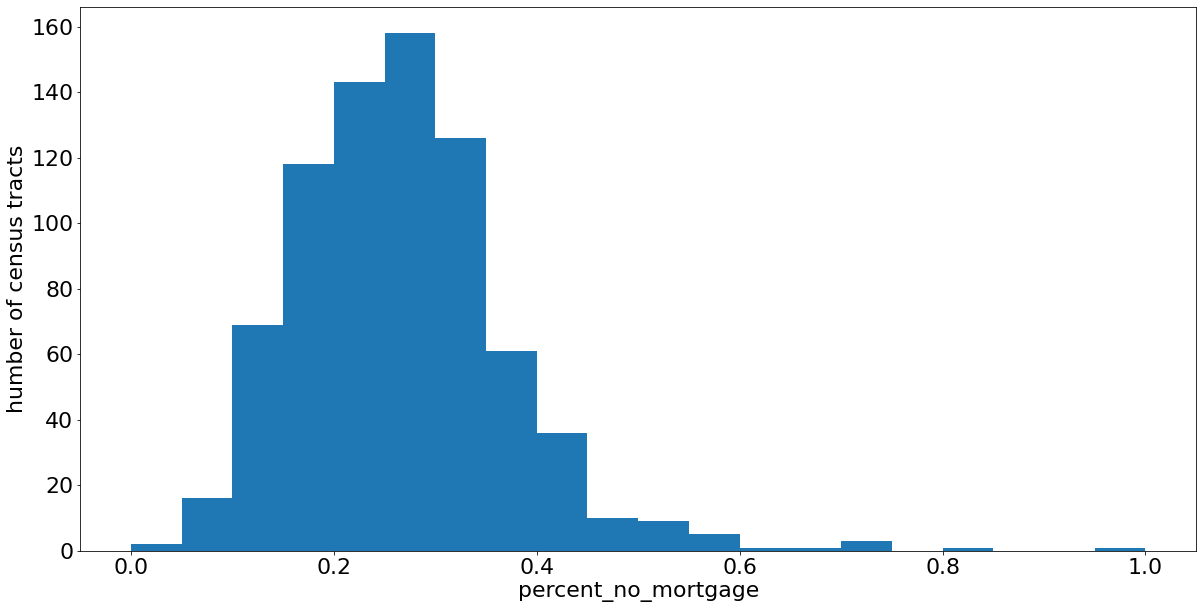

In [165]:
for column in mortgage_info_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(mortgage_info_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('humber of census tracts')
        plt.show()

In [166]:
# FINANCIAL CHARACTERISTICS FOR HOUSING UNITS WITH A MORTGAGE
mortgage_amount_df = read_in_dataset('mortgage_amount')
mortgage_amount_df = mortgage_amount_df[mortgage_amount_df['ct_key'].isin(denver_census_tracts)]

In [167]:
col = 'Estimate!!Owner-occupied housing units with a mortgage!!Owner-occupied housing units with a mortgage!!VALUE!!Median (dollars)'
mortgage_amount_df.rename(columns={col: 'median_mortgage_value'}, inplace=True)

In [168]:
mortgage_info_df = mortgage_info_df.merge(mortgage_amount_df[['ct_key', 'median_mortgage_value']],
                                          on='ct_key', how='left')

In [169]:
mortgage_info_df[(mortgage_info_df['median_mortgage_value'] == '-') |
                  mortgage_info_df['percent_mortgage'].isna() |
                  mortgage_info_df['percent_no_mortgage'].isna()]

,ct_key,percent_mortgage,percent_no_mortgage,median_mortgage_value
2,8031000800,0.169811,0.830189,-
152,8069000600,0.322581,0.677419,-
254,8001009103,0.497200,0.502800,-
288,8031007006,NaN,NaN,-
332,8005004952,1.000000,0.000000,-
382,8005006713,NaN,NaN,-
452,8069002803,0.000000,1.000000,-
503,8013012300,0.428571,0.571429,-
533,8005006501,0.740741,0.259259,-
615,8059009831,NaN,NaN,-


In [170]:
mean_median_mortgage_value = np.mean([int(x) for x in mortgage_info_df['median_mortgage_value'] if x != '-'])
mortgage_info_df['median_mortgage_value'] = [int(x) if x != '-' else mean_median_mortgage_value
                                             for x in mortgage_info_df['median_mortgage_value']]


for column in ['percent_mortgage', 'percent_no_mortgage']:
    mean_val = np.mean(mortgage_info_df[column])
    mortgage_info_df[column] = [x if pd.notnull(x) else mean_val
                                for x in mortgage_info_df[column]]

In [171]:
mortgage_info_df[(mortgage_info_df['median_mortgage_value'] == '-') |
                  mortgage_info_df['percent_mortgage'].isna() |
                  mortgage_info_df['percent_no_mortgage'].isna()]

,ct_key,percent_mortgage,percent_no_mortgage,median_mortgage_value


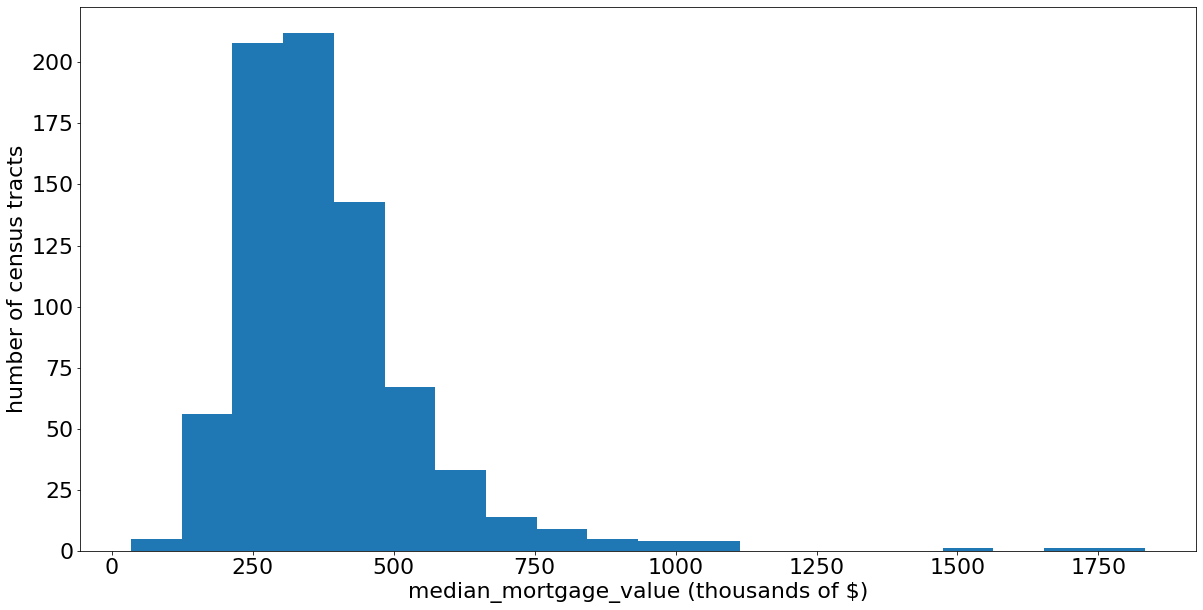

In [172]:
plt.figure(figsize=(20, 10))
plt.hist(mortgage_info_df['median_mortgage_value'] / 1000, bins=20)
plt.xlabel('median_mortgage_value (thousands of $)')
plt.ylabel('humber of census tracts')
plt.show()

In [173]:
ct_stats_df = ct_stats_df.merge(mortgage_info_df, on='ct_key', how='left')

### Vacancy

In [174]:
# OCCUPANCY STATUS
vacancy_df = read_in_dataset('vacancy')
vacancy_df = vacancy_df[vacancy_df['ct_key'].isin(denver_census_tracts)]

In [175]:
vacancy_df['vacancy_rate'] = vacancy_df['Estimate!!Total!!Vacant'] / vacancy_df['Estimate!!Total']
vacancy_df = vacancy_df[['ct_key', 'vacancy_rate']]

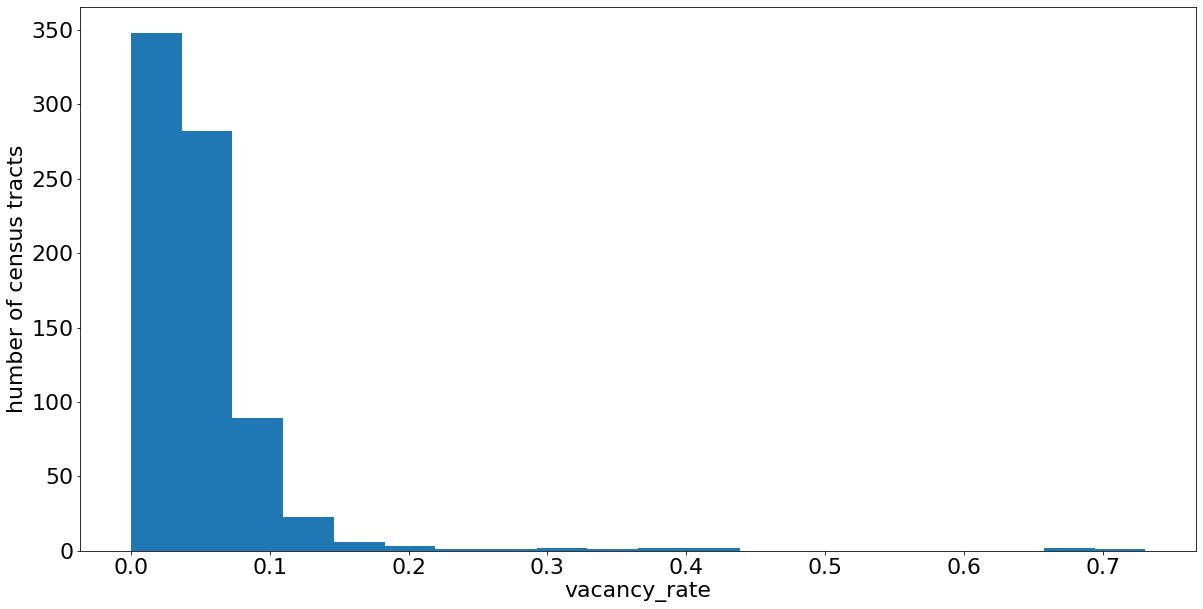

In [176]:
plt.figure(figsize=(20, 10))
plt.hist(vacancy_df['vacancy_rate'], bins=20)
plt.xlabel('vacancy_rate')
plt.ylabel('humber of census tracts')
plt.show()

In [177]:
ct_stats_df = ct_stats_df.merge(vacancy_df, on='ct_key', how='left')

### Own vs. Rent

In [178]:
# TENURE
renter_df = read_in_dataset('owner_vs_renter')
renter_df = renter_df[renter_df['ct_key'].isin(denver_census_tracts)]

In [179]:
renter_df.head(2)

,ct_key,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Owner occupied,Margin of Error!!Total!!Owner occupied,Estimate!!Total!!Renter occupied,Margin of Error!!Total!!Renter occupied
5,8031000201,"Census Tract 2.01, Denver County, Colorado",1618,86,1068,109,550,108
6,8031000600,"Census Tract 6, Denver County, Colorado",1859,142,411,91,1448,152


In [180]:
renter_df['renter_occupied_rate'] = renter_df['Estimate!!Total!!Renter occupied'] / renter_df['Estimate!!Total']
renter_df = renter_df[['ct_key', 'renter_occupied_rate']]

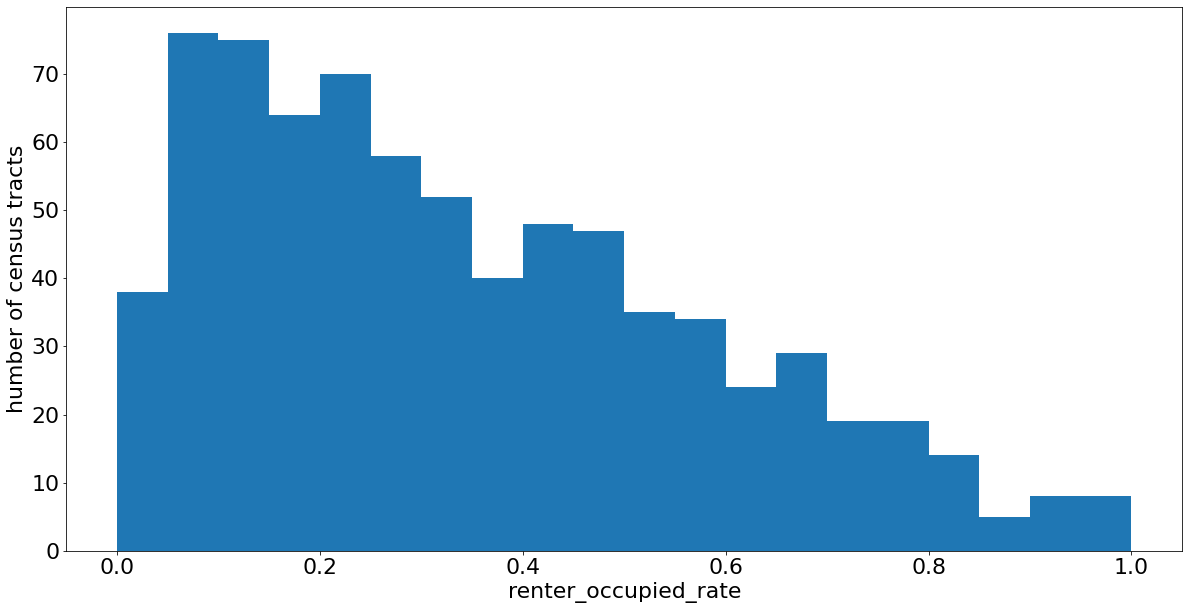

In [181]:
plt.figure(figsize=(20, 10))
plt.hist(renter_df['renter_occupied_rate'], bins=20)
plt.xlabel('renter_occupied_rate')
plt.ylabel('humber of census tracts')
plt.show()

In [182]:
ct_stats_df = ct_stats_df.merge(renter_df, on='ct_key', how='left')

In [183]:
ct_stats_df.head(5)

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,avg_member.sd,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,above_poverty_line,below_poverty_line,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,percent_no_mortgage,median_mortgage_value,vacancy_rate,renter_occupied_rate
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,18.064738,2.0,3.0,22.182277,14.754098,643.419355,485.000000,16.649502,1.000000,2.000000,13.874447,3.830084,4137,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.021030,0.459753,0.147450,0.117718,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,75.1,20.6,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,0.196262,173000.0,0.057437,0.916406
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,18.064738,2.0,3.0,22.182277,14.754098,643.419355,336.000000,18.300654,1.000000,1.000000,7.145540,0.313370,4664,0.286878,0.108276,0.164022,0.275515,0.082547,0.033662,0.032161,0.016938,0.569897,0.135077,0.182676,0.067753,0.033413,0.029529,0.024965,0.024260,0.012650,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,70.3,20.2,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,0.275591,256600.0,0.063513,0.912111
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,8

### Age of homes

In [184]:
# YEAR STRUCTURE BUILT
year_built_df = read_in_dataset('year_built')
year_built_df = year_built_df[year_built_df['ct_key'].isin(denver_census_tracts)]

In [185]:
column_to_new_column = {'2014 or later': '2014 or later',
                        '2010 to 2013': '2010-2013',
                        '2000 to 2009': '2000-2009'}

column_to_new_column = {'Estimate!!Total!!Built ' + column: 'built ' + new_column
                        for column, new_column in column_to_new_column.items()}

column_to_new_column['Estimate!!Total'] = 'total_households'

In [186]:
year_built_df = year_built_df[['ct_key'] + list(column_to_new_column)]
year_built_df.rename(column_to_new_column, axis=1, inplace=True)

In [187]:
for column in column_to_new_column.values():
    if column != 'total_households':
        year_built_df[column] = year_built_df[column] / year_built_df['total_households']

year_built_df.drop(columns=['total_households'], inplace=True)

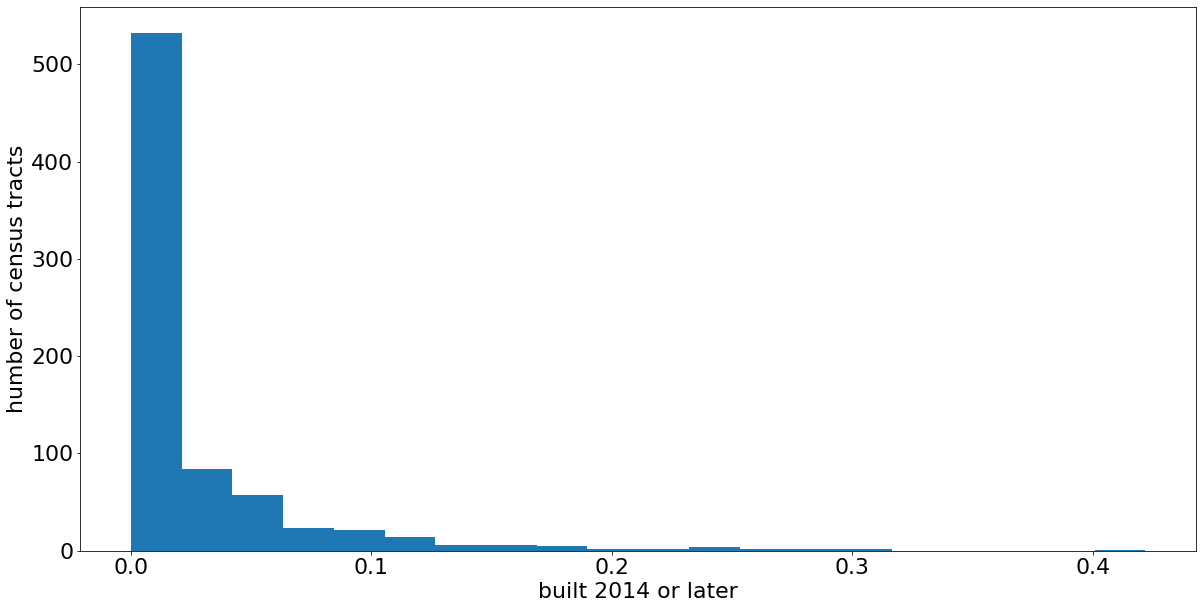

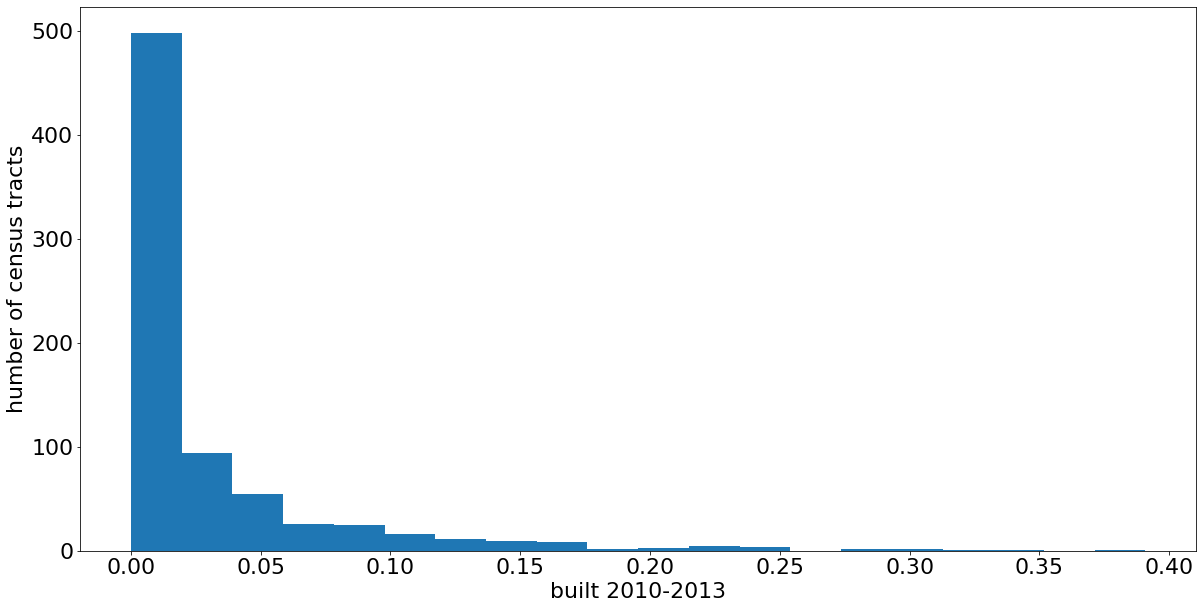

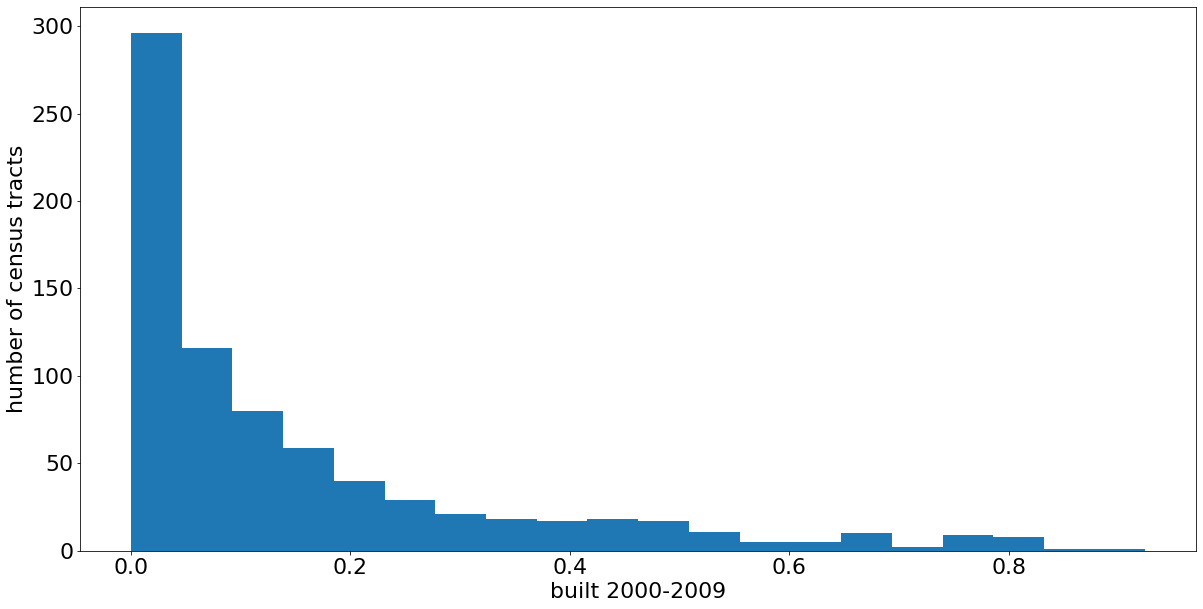

In [188]:
for column in year_built_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(year_built_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('humber of census tracts')
        plt.show()

In [189]:
ct_stats_df = ct_stats_df.merge(year_built_df, on='ct_key', how='left')

### Clean census-tract data

In [190]:
my_column_start = list(ct_stats_df.columns).index('census_population')
my_columns = ct_stats_df.columns[my_column_start:]
all_outlier_census_tracts = []
for column in my_columns:
    lower_extreme, upper_extreme = np.quantile(ct_stats_df[column], [0.02, 0.98])
    outlier_census_tracts = ct_stats_df[(ct_stats_df[column] <= lower_extreme) | 
                                        (ct_stats_df[column] >= upper_extreme)]['ct_key']
    all_outlier_census_tracts.extend(outlier_census_tracts) 

In [191]:
census_tracts_ranked = Counter(all_outlier_census_tracts).most_common(50)
worst_census_tracts = [x[0] for x in census_tracts_ranked]

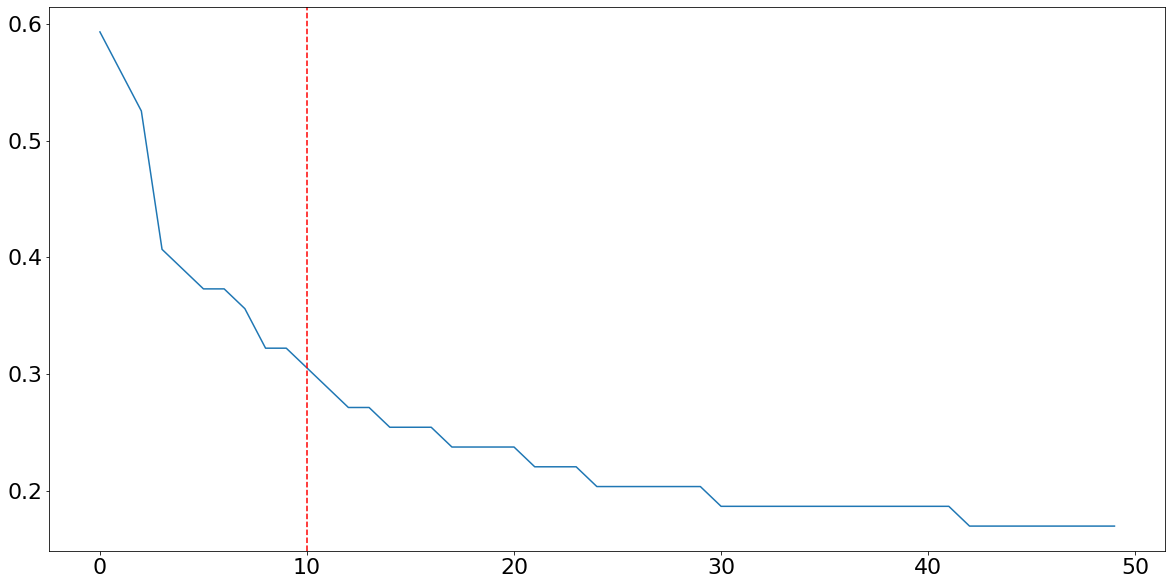

In [192]:
outlier_num_lst = [x[1] / len(my_columns) for x in census_tracts_ranked]
plt.figure(figsize=(20, 10))
plt.plot(outlier_num_lst)
plt.axvline(x=10, color='r', linestyle='--')
plt.show()

In [193]:
ct_stats_df[ct_stats_df['ct_key'].isin(worst_census_tracts[:10])]

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,avg_member.sd,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,above_poverty_line,below_poverty_line,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,percent_no_mortgage,median_mortgage_value,vacancy_rate,renter_occupied_rate,built 2014 or later,built 2010-2013,built 2000-2009
137,8005006705,3087.0,1.887129,3087.0,NaN,NaN,NaN,100.0,100.0,100.0,895.800427,70.0,50.0,0.0,20.0,30.0,15.572519,36.183206,40.152672,8.091603,97.099237,2.900763,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.900763,14.198473,38.625954,44.274809,0.0,0.000000,0.000000,0.000000,87.167449,12.832551,0.000000,2.442748,1.872474,100.000000,1.504358,100.000000,17.870989,45.630407,47.319145,23.400936,55.538222,17.940718,2.340094,0.780031,0.0,14.0,14.0,0.000000,8.009153,8.009153,81.515688,0.807927,0.065600,803345.0,16.116204,6.0,6.5,56.236203,58.333333,556.858660,495.142857,16.802929,7.309524,7.690476,71.043012,68.241905,2034,0.307276,0.047689,0.066863,0.160275,0.194199,0.073746,0.081613,0.068338,0.000000,0.969027,0.010816,0.007866,0.023923,0.016080,0.034756,0.028139,0.000000,0.409046,0.705529,0.051683,0.000000,0.000000,0.229567,0.013221,250000,250000,250000,396179,402361,193187,0.964006,0.035994,95.6,4.4,20.0,23.6,639,3.20000,1.480000,3.180000,0.000000,0.012681,0.000000,0.000000,0.057971,0.141304,0.788043,75.1,5.9,19.0,0.675045,0.324955,1.833300e+06,0.024427,0.128326,0.000000,0.000000,0.155725
184,8005081500,1642.0,8.160904,NaN,1780.0,1288.0,NaN,100.0,100.0,100.0,4351.758770,32.0,12.0,8.0,58.0,68.0,1.237729,91.762697,5.335041,1.664533,4.780196,15.151515,0.682885,79.385403,0.000000,0.0,0.554844,12.633376,67.093470,16.901408,2.816901,0.000000,0.0,0.000000,0.000000,0.000000,77.481273,22.518727,2.816901,8.834827,80.682724,16.629505,48.134412,100.000000,28.584784,57.173949,90.412164,14.913958,57.361377,21.223709,4.206501,2.294455,17.0,89.0,106.0,5.593945,29.285949,34.879895,46.147863,0.408262,0.000000,802625.0,17.897926,5.5,6.0,51.959950,50.956284,732.290560,522.333333,16.114993,4.000000,4.666667,41.599477,35.515320,2905,0.000000,0.000000,0.000000,0.030637,0.058520,0.087780,0.307057,0.516007,0.012048,0.928744,0.028571,0.014802,-0.007629,-0.012754,-0.008317,-0.012014,0.000000,0.207229,0.838870,0.000000,0.000000,0.000000,0.131229,0.029900,36471,54737,29464,46336,63518,37995,0.326779,0.673221,90.3,9.3,23.9,30.1,2136,2.04000,1.030000,1.360000,0.419886,0.447118,0.078531,0.008866,0.008233,0.029132,0.008233,43.8,48.8,7.4,0.408459,

`8005081500` appears to be a retirement community. 

`8013012300` is mostly college dorms

`8013012401` poor and very young census tract where most people rent

`8013012607` very young, almost everyone rents

`8069000600` is mostly college dorms

Census tracts to ignore:

`8123002017, 8123002006, 8069002803, 8031001902` all have a population less than 1,000

`8031000800` has a population of 1,462 and has a bunch of abnormal features.

In [194]:
census_tracts_to_ignore = [8069002803, 8123002006, 8123002017, 8031001902, 8031000800]

In [195]:
ct_stats_df_cleaned = ct_stats_df[~ct_stats_df['ct_key'].isin(census_tracts_to_ignore)]

In [196]:
ct_stats_df_cleaned.drop(columns=['rent_br3.ct', 'rent_br2.ct', 'rent_br1.ct', 'rent_br0.ct',
                                  'above_poverty_line', 'percent_no_mortgage'], inplace=True)

In [197]:
ct_stats_df_cleaned['rent.ct'] = [x if pd.notnull(x) else np.mean(ct_stats_df_cleaned['rent.ct'])
                                  for x in ct_stats_df_cleaned['rent.ct']]

In [198]:
ct_stats_df_cleaned['grrent_yield.ct'] = [x if pd.notnull(x) else np.mean(ct_stats_df_cleaned['grrent_yield.ct'])
                                  for x in ct_stats_df_cleaned['grrent_yield.ct']]

In [199]:
ct_stats_df_cleaned[ct_stats_df_cleaned['<200k'].isna()]

,ct_key,rent.ct,grrent_yield.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,avg_member.sd,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,below_poverty_line,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,renter_occupied_rate,built 2014 or later,built 2010-2013,built 2000-2009
144,8005006713,2186.0,3.188243,100.0,100.0,100.0,5996.973308,22.0,2.0,18.0,68.0,78.0,33.116883,63.744589,3.138528,0.0,2.922078,0.000000,9.090909,87.987013,0.0,0.0,7.683983,60.930736,29.653680,1.731602,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,100.0,0.649351,5.952381,85.421650,100.000000,15.026812,100.0,92.912920,6.073765,54.318238,39.107143,26.071429,22.232143,12.589286,0.000000,5.0,49.0,54.0,4.135649,40.529363,44.665012,79.950572,0.638843,0.127273,802910.0,17.731114,9.0,9.0,81.737622,87.158470,821.161765,883.100000,23.273977,7.487500,7.750000,73.085611,69.501749,1629,0.135052,0.122161,0.367710,0.199509,0.128913,0.020872,0.025783,0.000000,0.077962,0.566605,0.022713,0.240025,0.064573,0.057266,0.055589,0.050370,0.012277,0.704113,0.712293,0.067132,0.099390,0.091543,0.023540,0.006103,72340,77063,71154,78798,80972,77803,0.314154,0.685846,4.7,22.6,11.1,869,2.79,1.46,1.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8,16.9,46.3,0.732624,383130.942895,0.059524,1.0,0.175325,0.032468,0.123377
441,8031007006,1682.0,6.007733,100.0,100.0,100.0,6336.640171,20.0,0.0,20.0,70.0,80.0,25.520833,63.318452,11.160714,0.0,5.877976,0.483631,2.418155,91.220238,0.0,0.0,9.412202,50.855655,34.784226,3.645833,0.0,1.302083,0.0,0.0,0.0,0.0,0.0,100.0,1.227679,7.663690,89.220215,73.134147,59.485752,100.0,99.014270,30.678521,40.313179,13.773935,42.063002,25.849290,15.812230,2.501544,44.0,214.0,258.0,9.856631,47.939068,57.795699,50.606758,0.345832,0.222326,803360.0,14.952392,7.0,6.0,53.547777,63.387978,446.791262,550.866667,16.613019,5.000000,5.633333,51.757641,45.926184,5300,0.201132,0.144717,0.306038,0.246981,0.041321,0.046038,0.013774,0.000000,0.370377,0.313962,0.165660,0.139811,0.031479,0.033397,0.040471,0.042121,0.010943,0.633774,0.681155,0.119678,0.133075,0.014290,0.036023,0.015779,42133,47028,36955,51048,55912,45472,0.420629,0.579371,12.4,14.3,17.3,2482,2.93,1.39,2.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.1,14.1,52.8,0.732624,383130.942895,0.076637,1.0,0.005952,0.098586,0.150670
546,8059009831,1974.0,5.577899,100.0,100.0,100.0,3125.860073,43.0,23.0,0.0,47.0,57.0,10.360029,87.215283,2.424688,0.0,0.000000,1.396032,6.245408,92.358560,0.0,0.0,1.542983,40.558413,57.898604,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,100.0,0.000000,6.465834,88.883390,66.143701,34.

`8005006713`, `8031007006`, `8059009831` are 100% rent and have very few listings over the past 4.5 years so we ignore them

In [200]:
ct_stats_df_cleaned = ct_stats_df_cleaned[~ct_stats_df_cleaned['ct_key'].isin(
    [8005006713, 8031007006, 8059009831])]

In [201]:
ct_stats_df.shape

(763, 133)

In [202]:
ct_stats_df_cleaned.shape

(755, 127)

In [203]:
ct_stats_df_cleaned.isna().sum()

ct_key                              0
rent.ct                             0
grrent_yield.ct                     0
cos.ct                              0
lake.ct                             0
frm.ct                              0
pop_density.ct                      0
den.ct                              0
urb.ct                              0
sub.ct                              0
rur.ct                              0
rmt.ct                              0
new_pct.ct                          0
est_pct.ct                          0
old_pct.ct                          0
his_pct.ct                          0
det_pct.ct                          0
att_pct.ct                          0
sap_pct.ct                          0
lap_pct.ct                          0
mob_pct.ct                          0
oth_pct.ct                          0
bed0_pct.ct                         0
bed1_pct.ct                         0
bed2_pct.ct                         0
bed3_pct.ct                         0
bed4_pct.ct 

In [204]:
# ct_to_number_of_listings = dict(Counter(denver_listing_dates_ct_df['ct_key']))
# ct_to_number_of_listings[8059009831]

In [205]:
neighborhood_scout_columns = list(ct_stats_df_cleaned.columns)[1:70]

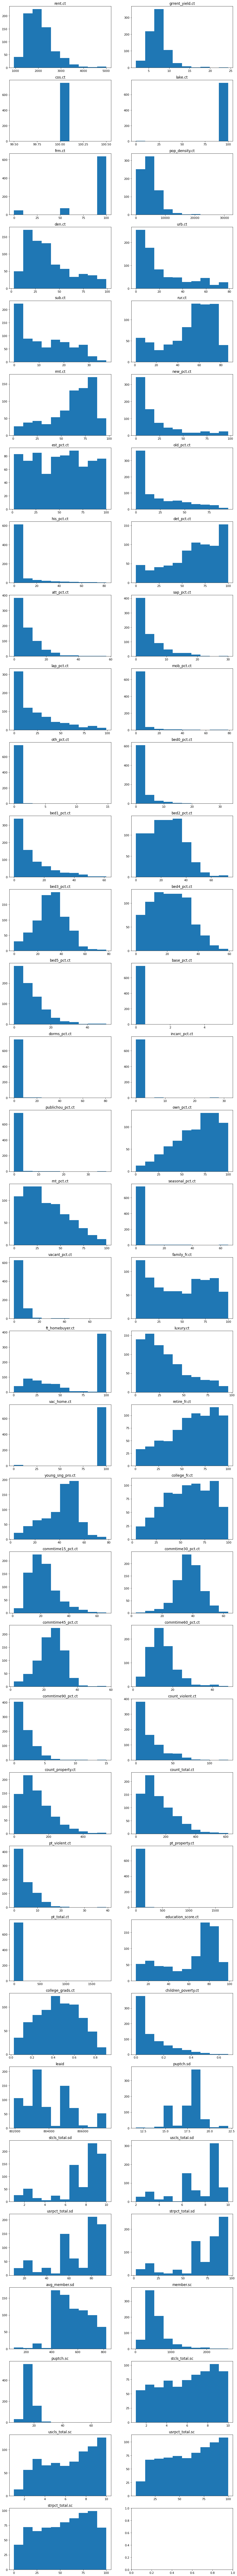

In [206]:
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(nrows=int(np.ceil(len(neighborhood_scout_columns) / 2)), ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(bottom=-8)
cnt = 0
for column in neighborhood_scout_columns:
    
    row_idx = int(cnt / 2)
    col_idx = cnt % 2
    
    axs[row_idx, col_idx].hist(ct_stats_df_cleaned[column])
    axs[row_idx, col_idx].set_title(column)
    
    cnt += 1

plt.rcParams.update({'font.size': 22})

Neighborhood Scout columns to drop:

`cos.ct`: all census tracts have same score 

`lake.ct`: the vast majority of census tracts have the same score

`oth_pct.ct`: value is 0 for vast majority of census tracts and statistic doesn't tell us much

`base_pct.ct`: values is 0 except for one census tract

`dorms_pct.ct`: vast majority of values are 0

`incarc_pct.ct`: vast majority of values of 0

`publichou_pct.ct`: vast majority of values are 0

`vac_home.ct`: vatst majority of scores are 100

`count_violent.ct`: raw count that isn't normalized

`count_property.ct`: raw count that isn't normalized

`count_total.ct`: raw count that isn't normalized

`pt_total.ct`: already broken up into violent crime rate and property crime rate

`leaid`: meaningless

In [207]:
neighborhood_scout_columns_to_drop = [
    'cos.ct', 'lake.ct', 'oth_pct.ct', 'base_pct.ct', 'dorms_pct.ct', 'incarc_pct.ct', 'publichou_pct.ct',
    'vac_home.ct', 'count_violent.ct', 'count_property.ct', 'count_total.ct', 'pt_total.ct', 'leaid'
]
ct_stats_df_cleaned.drop(columns=neighborhood_scout_columns_to_drop, inplace=True)

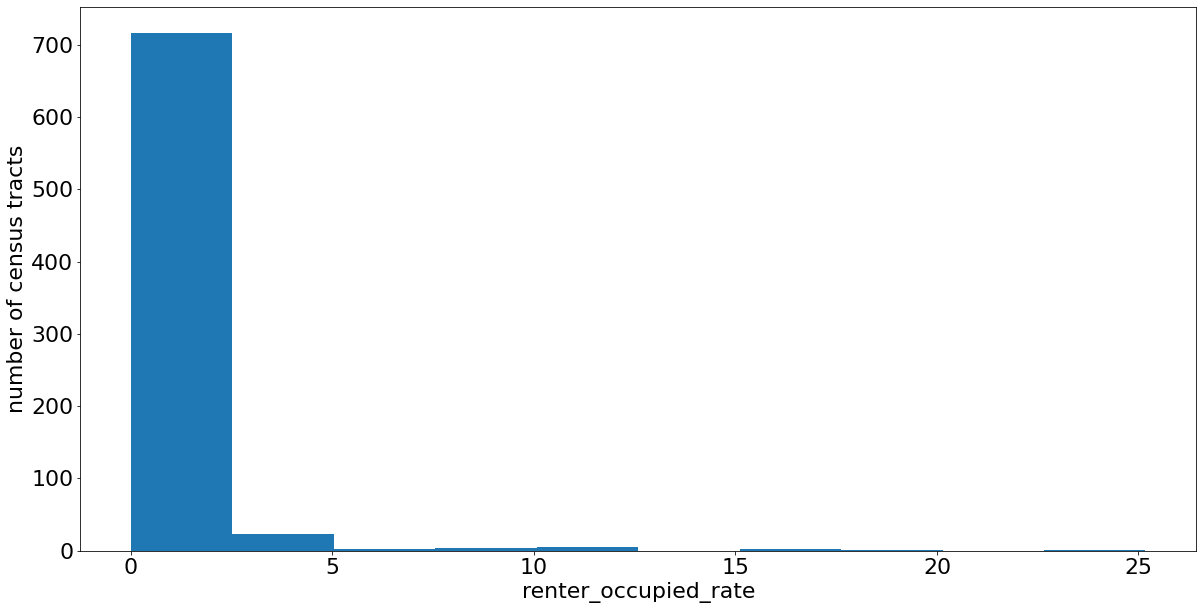

In [208]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df_cleaned['rnt_pct.ct'] - 100 * ct_stats_df_cleaned['renter_occupied_rate'])
plt.xlabel('renter_occupied_rate')
plt.ylabel('number of census tracts')
plt.show()

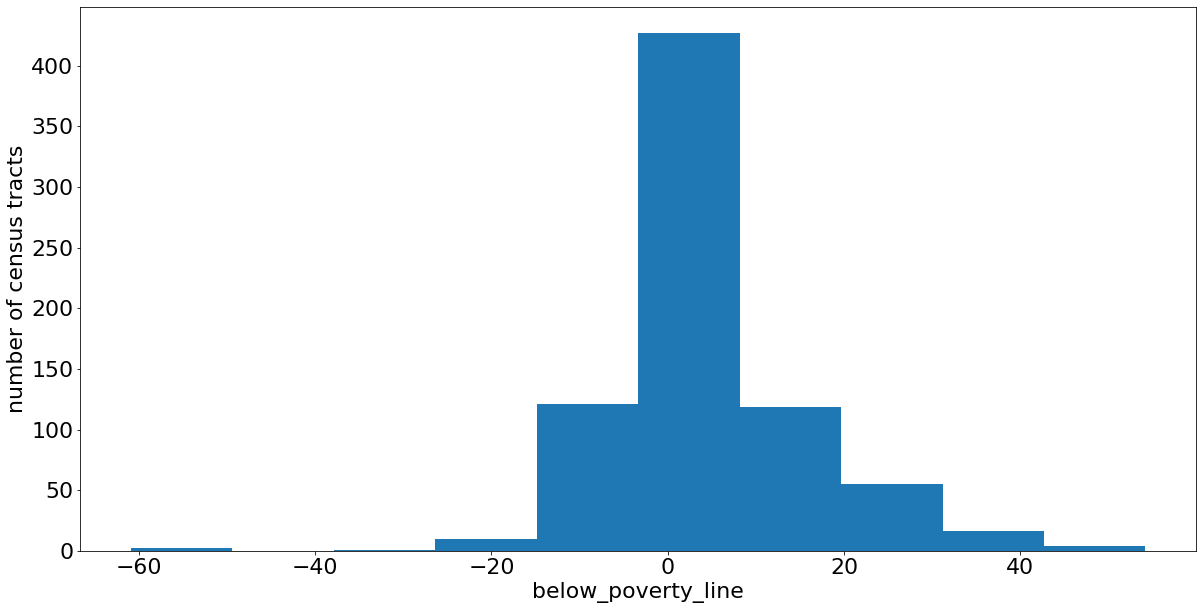

In [209]:
plt.figure(figsize=(20, 10))
plt.hist(100 * ct_stats_df_cleaned['children_poverty.ct'] - ct_stats_df_cleaned['below_poverty_line'])
plt.xlabel('below_poverty_line')
plt.ylabel('number of census tracts')
plt.show()

In [210]:
ct_stats_df_cleaned.drop(columns=['renter_occupied_rate', 'below_poverty_line'], inplace=True)

In [211]:
ct_stats_df_cleaned.shape

(755, 112)

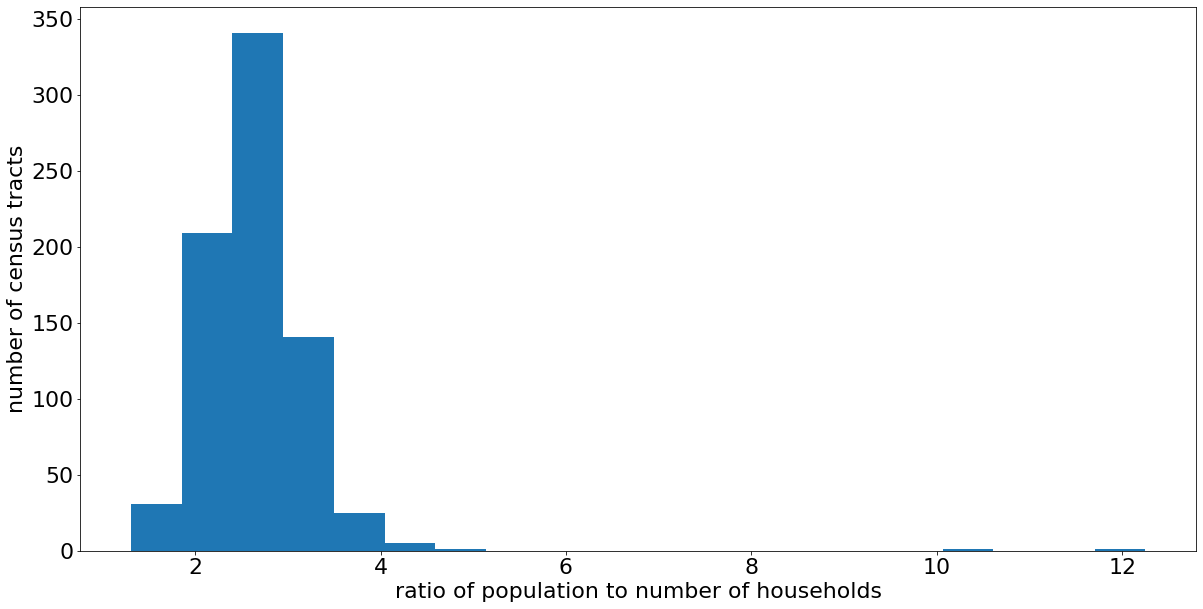

In [212]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df_cleaned['census_population'] / ct_stats_df_cleaned['total_households'], bins=20)
plt.xlabel('ratio of population to number of households')
plt.ylabel('number of census tracts')
plt.show()

In [213]:
neighborhoood_scout_columns_to_new_columns = {
    'rent.ct': 'median_rental_price',
    'grrent_yield.ct': 'average_annual_rent_as_percentage_of_property_value',
    'frm.ct': 'farm_score',
    'pop_density.ct': 'pop_density',
    'den.ct': 'densely_urban_score',
    'urb.ct': 'urban_score',
    'sub.ct': 'suburban_score',
    'rur.ct': 'rural_score',
    'rmt.ct': 'remote_score',
    'new_pct.ct': 'built 1995 or later',
    'est_pct.ct': 'built 1970-1994',
    'old_pct.ct': 'built 1940-1969',
    'his_pct.ct': 'built before 1940',
    'det_pct.ct': 'single_family_detached_pct',
    'att_pct.ct': 'rowhouses_and_attached_homes_pct',
    'sap_pct.ct': 'small_apt_buildings_pct',
    'lap_pct.ct': 'complexes/high_rise_apt_pct',
    'mob_pct.ct': 'mobile_home_pct',
    'bed0_pct.ct': '0_bedroom_pct',
    'bed1_pct.ct': '1_bedroom_pct',
    'bed2_pct.ct': '2_bedroom_pct',
    'bed3_pct.ct': '3_bedroom_pct',
    'bed4_pct.ct': '4_bedroom_pct',
    'bed5_pct.ct': '5_bedroom_pct',
    'own_pct.ct': 'homeownership_rate',
    'rnt_pct.ct': 'rental_rate',
    'seasonal_pct.ct': 'seasonal_housing_pct',
    'vacant_pct.ct': 'vacant_homes_pct',
    'family_fr.ct': 'family_friendly_score',
    'ft_homebuyer.ct': 'first_time_homebuyer_score',
    'luxury.ct': 'luxury_communities_score',
    'retire_fr.ct': 'retirement_friendly_score',
    'young_sng_pro.ct': 'young_single_professional_score',
    'college_fr.ct': 'college_student_friendly_score',
    'commtime15_pct.ct': 'commute_under_15_min_pct',
    'commtime30_pct.ct': 'commute_15-30_min_pct',
    'commtime45_pct.ct': 'commute_30-45_min_pct',
    'commtime60_pct.ct': 'commute_45-60_min_pct',
    'commtime90_pct.ct': 'commute_over_60_min_pct',
    'pt_violent.ct': 'violent_crime_rate',
    'pt_property.ct': 'property_crime_rate',
    'education_score.ct': 'standardized_test_score_percentile',
    'college_grads.ct': 'pct_pop_at_least_college_degree',
    'children_poverty.ct': 'children_poverty_pct',
    'puptch.sd': 'student_to_teacher_ratio_sd',
    'stcls_total.sd': 'state_index_total_achievement_sd',
    'uscls_total.sd': 'national_index_total_achievement_sd',
    'usrpct_total.sd': 'national_percentile_total_achievement_sd',
    'strpct_total.sd': 'state_percentile_total_achievement_sd',
    'avg_member.sd': 'average_number_of_students_per_school_sd',
    'member.sc': 'number_of_students_sc',
    'puptch.sc': 'student_to_teacher_ratio_sc',
    'stcls_total.sc': 'state_index_total_achievement_sc',
    'uscls_total.sc': 'national_index_total_achievement_sc',
    'usrpct_total.sc': 'national_percentile_total_achievement_sc',
    'strpct_total.sc': 'state_percentile_total_achievement_sc',
}

In [214]:
ct_stats_df_cleaned.rename(neighborhoood_scout_columns_to_new_columns, axis=1, inplace=True)

In [215]:
ct_stats_df_cleaned.to_csv('denver_census_tract_data.csv', index=False)

In [216]:
redundant_columns = [
    'densely_urban_score', 'remote_score', 'built 2000-2009', 'state_index_total_achievement_sd',
    'national_index_total_achievement_sd', 'state_percentile_total_achievement_sd', 
    'state_index_total_achievement_sc', 'state_percentile_total_achievement_sc', 
    'national_index_total_achievement_sc', 'avg_annual_pop_change_since_2010',
    'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014',
    'mean_household_income', 'median_family_income', 'mean_family_income', 'vacancy_rate',
    'standardized_test_score_percentile'
]

In [217]:
ct_stats_df_cleaned.drop(columns=redundant_columns, inplace=True, errors='ignore')

In [218]:
ct_stats_df_cleaned.to_csv('denver_census_tract_data_removed_redundant_features.csv', index=False)

### MLS Listing Data

In [219]:
denver_listing_dates_df = pd.read_csv('denver_listing_dates_cleaned.csv')
denver_listing_dates_df['zipcode'] = denver_listing_dates_df['zipcode'].astype(str)

In [220]:
for event in 'list sale withdrawn expired cancelled'.split():
    column = event + '_date'
    denver_listing_dates_df[column] = pd.to_datetime(denver_listing_dates_df[column]).dt.date

In [221]:
denver_listing_dates_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price
0,666680976,80113,39.65232,-104.97613,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN
1,138826052,80123,39.62523,-105.08648,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN
2,666683709,80204,39.74122,-105.05241,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN
3,137981678,80241,39.91465,-104.93076,2016-03-01,2016-04-21,NaT,NaT,NaT,Sale,320000.0
4,410875086,80202,39.74783,-104.98640,2016-03-01,2016-05-02,NaT,NaT,NaT,Sale,475000.0


In [222]:
# shapefile of all census tracts
census_tracts_shapes = gpd.read_file('neighborhood_scout_data/ct_18states shapefile/ct_18states.shp')
census_tracts_shapes['ct_key'] = census_tracts_shapes['CT_KEY'].astype(int)
census_tracts_shapes.drop(columns='CT_KEY', inplace=True)

# limit analysis to census tracts in Colorado
colorado_census_tracts_shapes = census_tracts_shapes[census_tracts_shapes['ct_key'].isin(colorado_census_tracts)]
colorado_census_tracts_shapes.shape

(1249, 2)

In [223]:
# convert the latitude and longitude of each listing to a Point
geometry = [Point(xy) for xy in zip(denver_listing_dates_df.longitude, denver_listing_dates_df.latitude)]
gdf = gpd.GeoDataFrame(denver_listing_dates_df, crs='EPSG:4269', geometry=geometry)

# identify the census tract that each listing lies within
merged_file = gpd.sjoin(gdf, colorado_census_tracts_shapes, how='left', op='within')
denver_listing_dates_ct_df = pd.DataFrame(merged_file)

In [224]:
denver_listing_dates_ct_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,666680976,80113,39.65232,-104.97613,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN,POINT (-104.97613 39.65232),10693.0,8.005006e+09
1,138826052,80123,39.62523,-105.08648,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN,POINT (-105.08648 39.62523),9869.0,8.059012e+09
2,666683709,80204,39.74122,-105.05241,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN,POINT (-105.05241 39.74122),10476.0,8.031001e+09
3,137981678,80241,39.91465,-104.93076,2016-03-01,2016-04-21,NaT,NaT,NaT,Sale,320000.0,POINT (-104.93076 39.91465),9719.0,8.001009e+09
4,410875086,80202,39.74783,-104.98640,2016-03-01,2016-05-02,NaT,NaT,NaT,Sale,475000.0,POINT (-104.98640 39.74783),10465.0,8.031002e+09


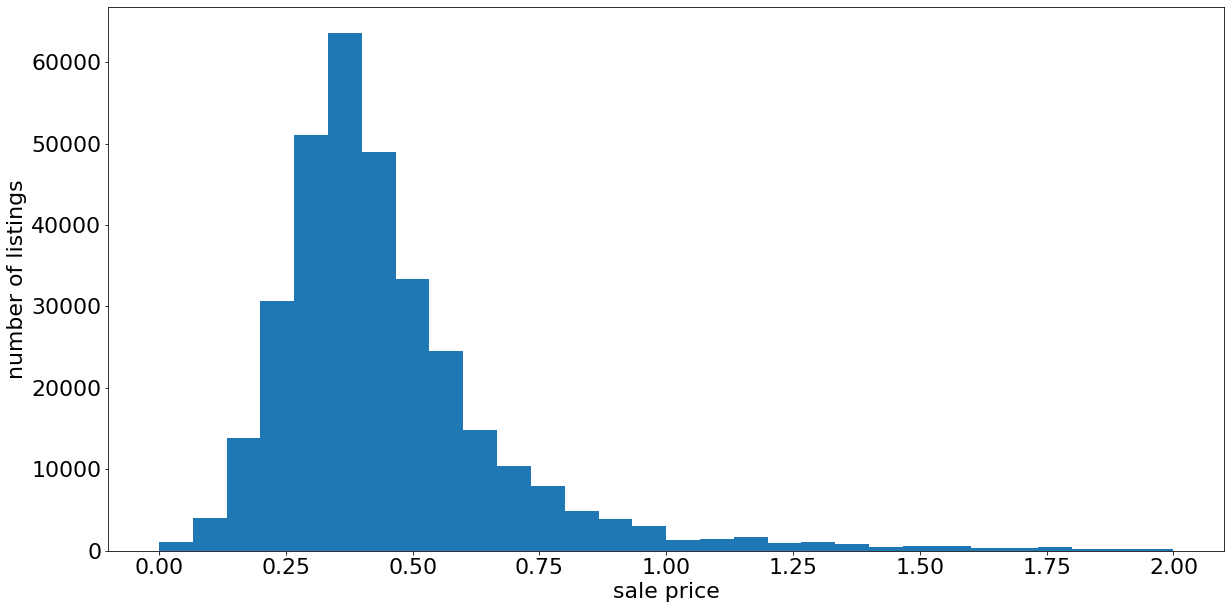

In [225]:
plt.figure(figsize=(20, 10))
plt.hist([x / 1e6 for x in denver_listing_dates_ct_df['sale_price'] if pd.notnull(x) and x < 2e6], bins=30)
plt.xlabel('sale price')
plt.ylabel('number of listings')
plt.show()

In [226]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude             544
longitude            544
list_date              0
sale_date         111519
withdrawn_date    402008
expired_date      418602
cancelled_date    440220
current_status         0
sale_price        111708
geometry               0
index_right          569
ct_key               569
dtype: int64

In [227]:
# ignore the listings that aren't matched up with a census tracts
denver_listing_dates_ct_df = denver_listing_dates_ct_df[denver_listing_dates_ct_df['ct_key'].notna()]

In [228]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude               0
longitude              0
list_date              0
sale_date         111428
withdrawn_date    401461
expired_date      418066
cancelled_date    439653
current_status         0
sale_price        111617
geometry               0
index_right            0
ct_key                 0
dtype: int64

In [229]:
final_census_tracts = set(ct_stats_df_cleaned['ct_key'])

In [230]:
print(len(denver_listing_dates_ct_df))
denver_listing_dates_ct_df = denver_listing_dates_ct_df[
    denver_listing_dates_ct_df['ct_key'].isin(final_census_tracts)]
print(len(denver_listing_dates_ct_df))

439732
439427


In [231]:
denver_listing_dates_ct_df.to_csv('denver_listing_dates_with_ct.csv', index=False)